<a href="https://colab.research.google.com/github/uomodellamansarda/clockworkcsvestimator/blob/master/Workout_Analyzer_Eng_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is made to analyze Pomodoro Techniques Logs and undersand how well Data Science with Python practice is going. 
Practice could be study, no profit project, work, even reading a data book.

The goal is to reach 10.000 hours to be an expert. 
It's just a trivial proxy, but gives an idea and a direction and it's enough. 

The code is made to compare the efforts with a 3h daily ideal and costant practice. 

At the end of the code, after analyzed the past data as a report and feedback session, I made three estimation about the remaining time based on:

-Markov Inequality 

-Linear regression (I know that variables are not indipendently and identically distributed)

-Non Linear Regression using Prophet, an open source library developed by Facebook 

NOTE
If the time series is not stationary, or any of its possible trasformations you could not evaluate autocorrelation and partial correlation 

In the Year, Month, Week Analysis, I should create a logic that starts counting from the current day, instead at the moment it starts counting from the last log

#1 Library Setup


In [116]:
#Google Drive Pre-work
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [117]:
#importing all the necessary libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import scipy.stats

#Autentication Section

In [118]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#DataLoading

In [115]:
#global variables of interest 

va='Python'
tvoi='Length'

#goal expressed in hours to be reached 
h=10000

#Link to the data source that is a csv file in drive
print("Please Insert the link to the Google Drive File")
namepath= input( )

id=namepath.split('/')[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  

# Dataset is now stored in a Pandas Dataframe
csvname="Filename.csv"
#read the csv
#The number of columns from the app csv file is known	
columns_name=['Year', 'Month', 'Day', 'Time', 'Length', 'Start', 'End', 'Activity']
dfraw=pd.read_csv(csvname,names=columns_name,sep=',',skiprows=1,skipfooter=0, index_col=False)
print("Printing the data type of the time variable:")
print(type(dfraw[tvoi].iloc[0]))
dfraw[tvoi] = dfraw[tvoi].astype('str')
#We throw away time variables longer than 6 characters
# 00:00:00 if there is any variable 
# longer should be an error
mask = (dfraw[tvoi].str.len() == 6) 
dfraw = dfraw.loc[mask]
#removing all the white spaces
dfraw[tvoi]=dfraw[tvoi].str.strip()
#Converting to datetime datatype the time column
dfraw[tvoi]=pd.to_datetime(dfraw[tvoi], format='%M:%S')
#Merging in one date thre columns containing
#Year Month Day Informations
dfraw['Date'] = dfraw.apply(lambda row: datetime(row['Year'], row['Month'], row['Day']), axis=1)

#The code extracts all the logs containing the Python
#or python word
pythondf=dfraw[(dfraw['Activity'].str.contains("Python",na=False)) | (dfraw['Activity'].str.contains("python",na=False))] 


Please Insert the link to the Google Drive File
https://drive.google.com/file/d/1mbW7YyNbQV3M7LgTVxWeR_rt4tjA2PfZ/view?usp=sharing


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1mbW7YyNbQV3M7LgTVxWeR_rt4tjA2PfZ?alt=json


Printing the data type of the time variable:
<class 'str'>


## Resampling

In [119]:
#We create a copy of 
#the dataframe containing only the 
#python records and
#we aggregate on daily basis 


rs_df=pythondf.groupby('Date').count().copy()
#We resample the dataframe in order to have 
#a continues time series 
#with daily frequency
#we fill missing values with 0
rs_df=rs_df.resample('D').asfreq().fillna(0)
#divide by 2 because each pomodoro record lasts 25 minutes
#and we create a new column to keep track of that
#NOTE!
#this transformation is needed 
#only for the Actual cumulated column
#not for the ideal one already expressed in terms of hours  
rs_df['Cum']=rs_df['Activity'].cumsum().divide(2)
#3 hours is the minimum ideal time to find during the day
#to practice with python 
#ideally with 3 hours a day 
#you will become a python expert after 9 years
rs_df['Costant_CUM']=3
rs_df['Costant_CUM']=rs_df['Costant_CUM'].cumsum()


#Hours Remaining to be an expert

In [120]:
#Max Hours 
max_hours=rs_df['Cum'][-1]
print("Total hours Dedicated until now",max_hours)
remaining_h=h-max_hours
print("Remaining hours to became an expert: \n",remaining_h)
print(type(rs_df.index[0]))
print()

Total hours Dedicated until now 2485.0
Remaining hours to became an expert: 
 7515.0
<class 'pandas._libs.tslibs.timestamps.Timestamp'>



#Plotting Functions

In [121]:
#We create a function 
#in order to plot all the hours dedicated to the 
#Variable of Interest (in this specific case python)
#And we compare with the "hours per day  goal"

def practice_plot(df):
  #maxh will stores the maximum cumulated hours 
  #actually dedicated
  #to the goal 
  maxh=df.Cum.max()
  #maxc will stores the maximum cumulated hours 
  #ideally dedicated
  #to the goal (3h per week since started studying python) 
  maxc=df.Costant_CUM.max()
  print("Max Hours of practice with ",va, " is %d h"%maxh)
  delta=maxh-maxc
  print("Python Logs starts",rs_df.index[0].date(), "and they end",rs_df.index[-1].date())
  print("The difference between the actual cumulated hours and the ideal cumulated hours is: %s hours \n"%delta)

  def plotting(df):
    fig, ax= plt.subplots(figsize=(15,10),
                          facecolor='white', dpi=300)
    #We plot and compare the actual trend
    #with the ideal    
    ax.plot(df.index,df['Cum'])
    ax.plot(df.index,df['Costant_CUM'],'g--')
    ax.tick_params(axis='x',rotation=90)
    ax.set(title='Total Hours Studying and Working With Python (%d H)'%(maxh))
    plt.show()
    return 
#We can give to the function
#different DataFram
#We must be aware if they are 
#longer or shorter of 180/90/30 days    
  if len(df)>180:
    #Windows length expressed in days 
    #30 90 180 days               
    delta_mens=[-30,-90,-180]
    delta_mens_pos=res =[abs(ele) for ele in delta_mens]
    delta_mens_dic={"Monthly":-30,"Quarter":-90,"Semester":-180}
    z=df['Cum'].iloc[-1]
    y=df['Costant_CUM'].iloc[-1]

    percentage_change=[(((maxh-maxc)/(df['Cum'].iloc[x]-df['Costant_CUM'].iloc[x]))*100).round(2) for x in delta_mens]
    for c,value in enumerate(percentage_change):
      #we need this section in order to 
      #deal when the ratio is >0 or <0
      #this will happens when both numerator
      #and denominator will be >0
      
      if value<0:
        
        percentage_change=round(value-100,2)
        print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))
      elif value>0: 
         
        percentage_change=round(100-value,2)
        print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))    
      else:
        print('Something went wrong my friend!')
    plotting(df)    
  elif len(df)>90:
      delta_mens=[-30,-90]
      delta_mens_pos=res =[abs(ele) for ele in delta_mens]
      delta_mens_dic={"Monthly":-30,"Quarter":-90}
      percentage_change=[(((maxh-maxc)/(df['Cum'].iloc[x]-df['Costant_CUM'].iloc[x]))*100).round(2) for x in delta_mens]
      
      for c,value in enumerate(percentage_change):
        
      #we need this section in order to 
      #deal when the ratio is >0 or <0
      #this will happens when both numerator
      #and denominator will be >0
        if value<0:
          percentage_change=round(value-100,2)
          print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))
        elif value>0:         
          percentage_change=round(100-value,2)
          print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))    
        else:
          print('Something went wrong my friend!')
      plotting(df)    
      
      
  elif len(df)<90:
    #if the length is smaller than a quarter 
    #we don't compute the relative ratio
      plotting(df)
    
    

#Since Ever Plot

Max Hours of practice with  Python  is 2485 h
Python Logs starts 2017-08-02 and they end 2020-07-01
The difference between the actual cumulated hours and the ideal cumulated hours is: -710.0 hours 

Spread between Ideal and Actual hours reduced by 2.87  in the past 30 days 
Spread between Ideal and Actual hours reduced by 0.42  in the past 90 days 
Spread between Ideal and Actual hours reduced by 24.27  in the past 180 days 


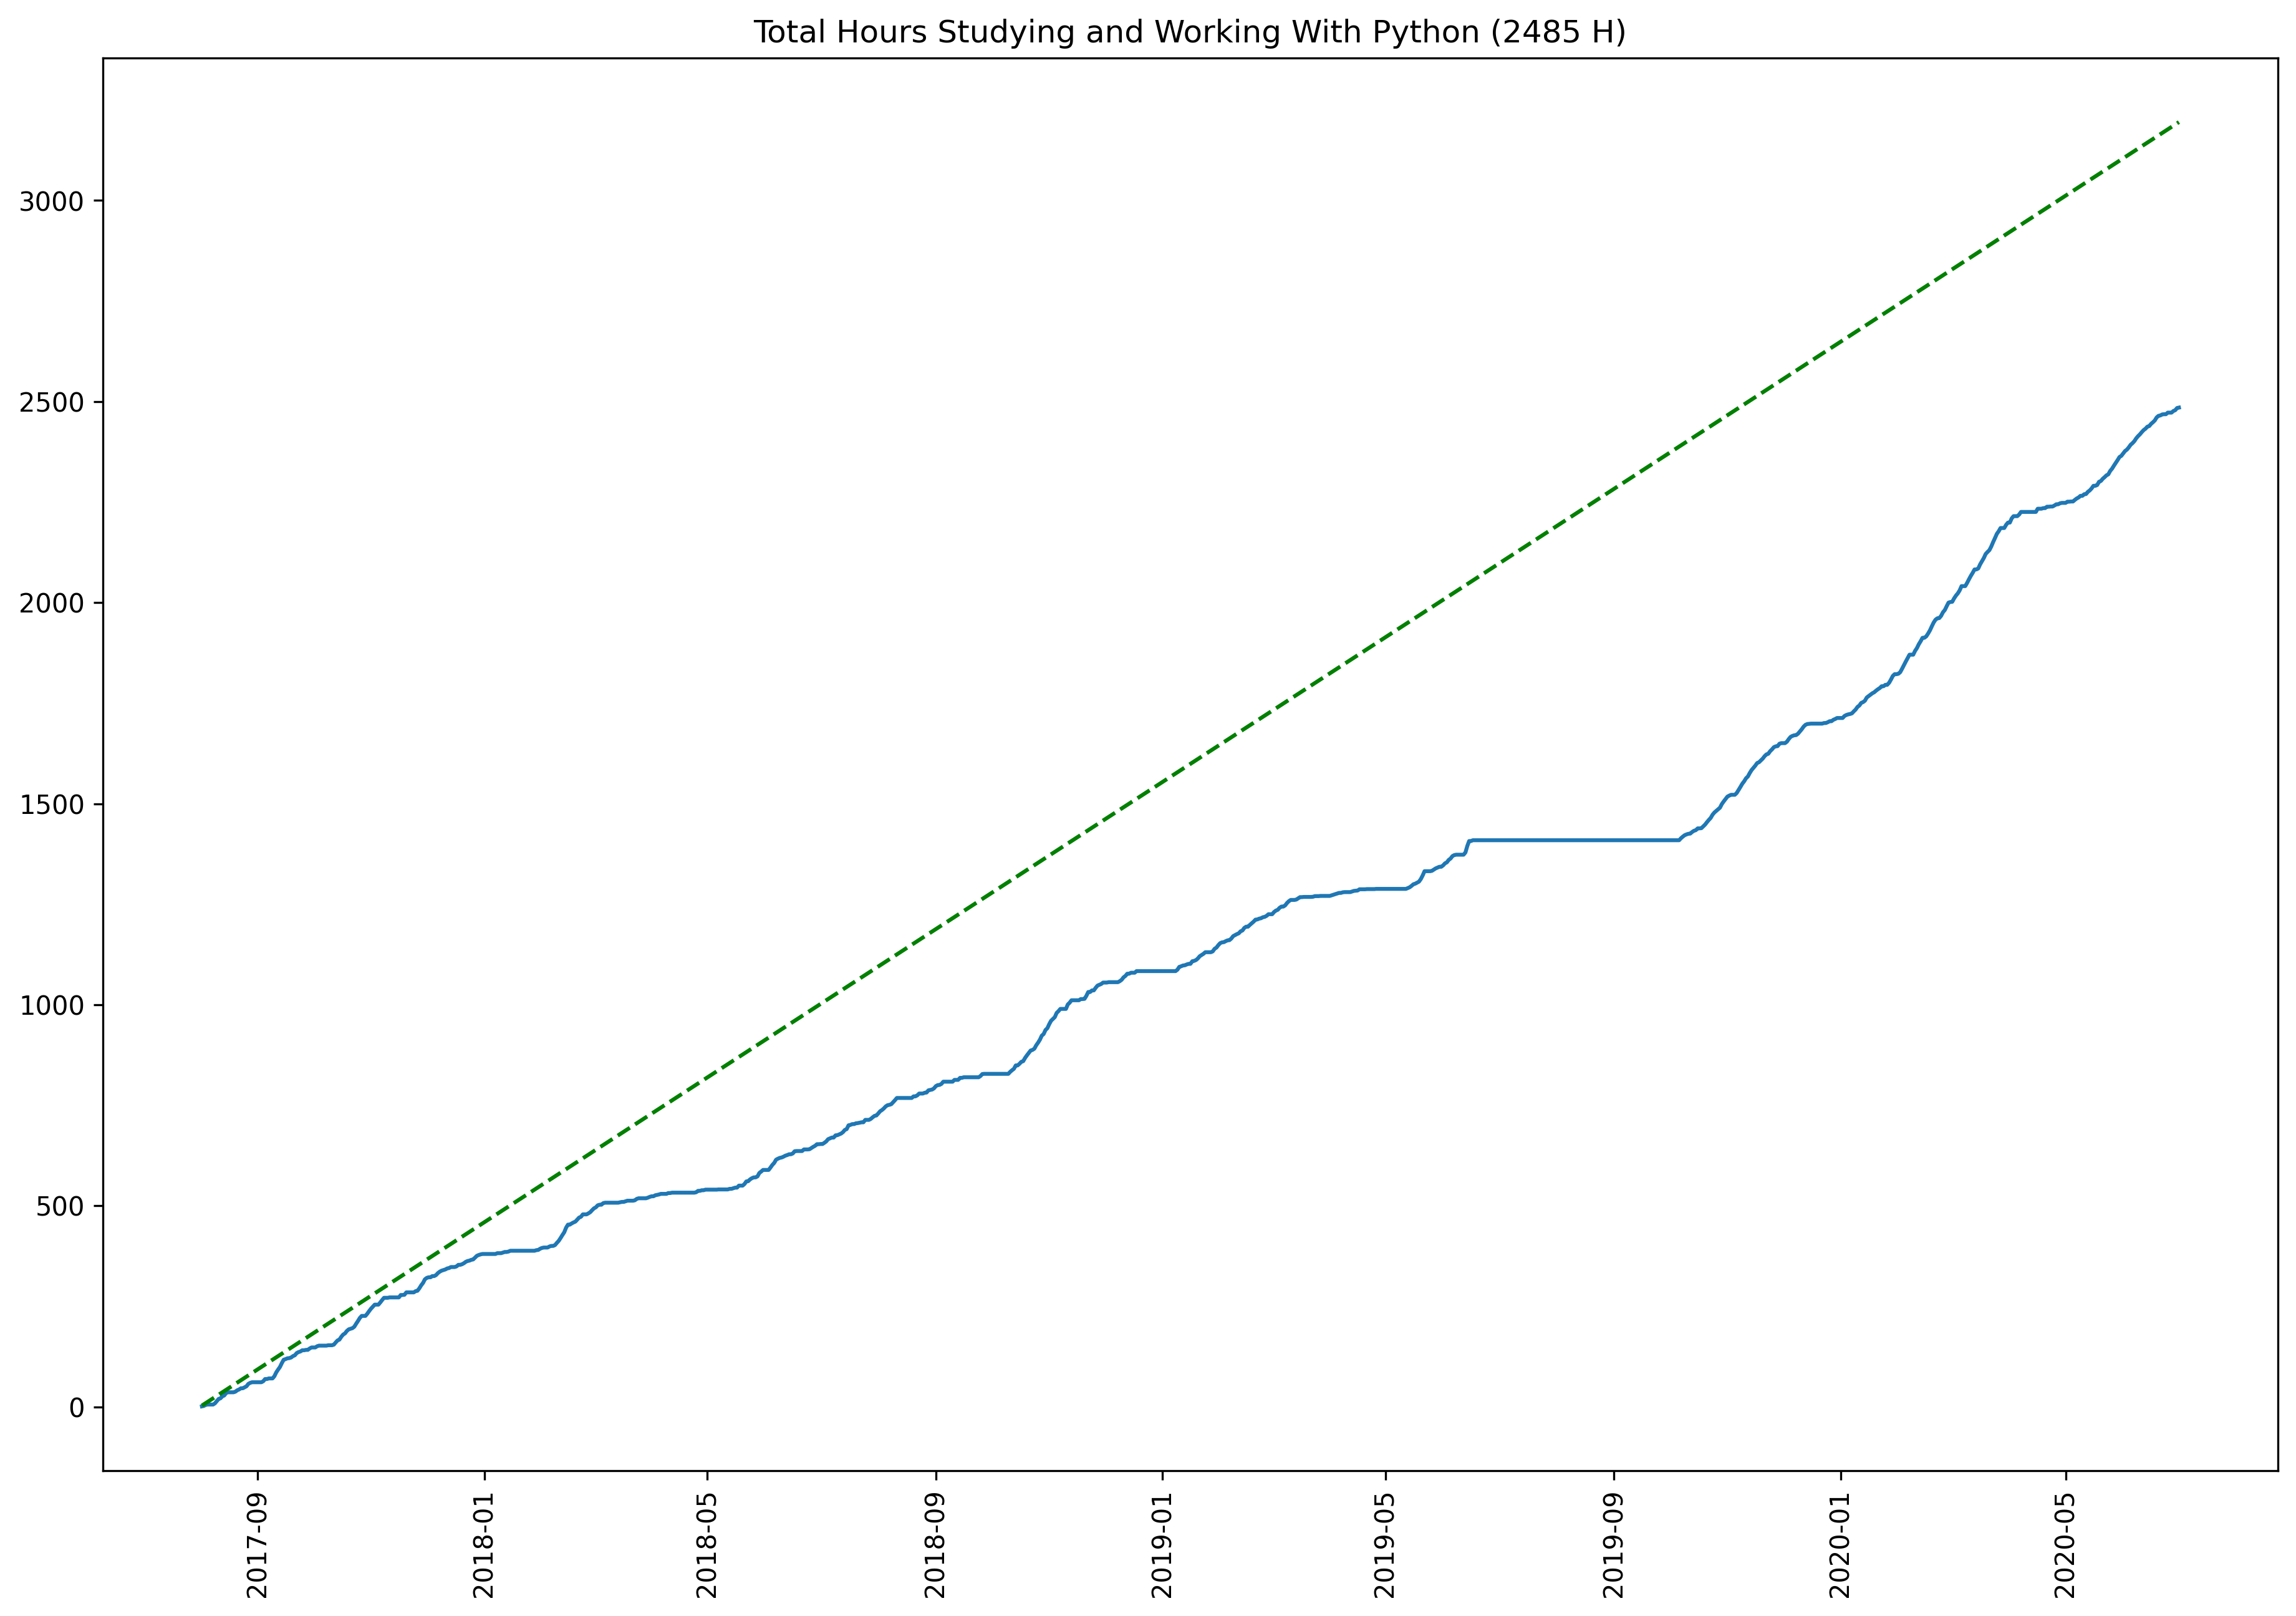

In [122]:
practice_plot(rs_df)

#Current Year Analysis

In [123]:
#we create a copy in order to modify without 
#corrupting the original df
#containing all the records 
#of the selected activity
#grouped by day 
pythondf=rs_df
#this is a test for timeseries slicing
print("Slicing test for current year \n", pythondf['2020'].tail())
print(pythondf.head())
print(pythondf.index[1:10])
#here you can put automatically the year
select_Year='2019'
start=-365
print(len(pythondf.iloc[start:]))

Slicing test for current year 
             Year  Month   Day  Time  ...   End  Activity     Cum  Costant_CUM
Date                                 ...                                     
2020-06-27   0.0    0.0   0.0   0.0  ...   0.0       0.0  2472.5         3183
2020-06-28   8.0    8.0   8.0   8.0  ...   8.0       8.0  2476.5         3186
2020-06-29   4.0    4.0   4.0   4.0  ...   4.0       4.0  2478.5         3189
2020-06-30  11.0   11.0  11.0  11.0  ...  11.0      11.0  2484.0         3192
2020-07-01   2.0    2.0   2.0   2.0  ...   2.0       2.0  2485.0         3195

[5 rows x 10 columns]
            Year  Month  Day  Time  ...  End  Activity  Cum  Costant_CUM
Date                                ...                                 
2017-08-02   2.0    2.0  2.0   2.0  ...  2.0       2.0  1.0            3
2017-08-03   2.0    2.0  2.0   2.0  ...  2.0       2.0  2.0            6
2017-08-04   5.0    5.0  5.0   5.0  ...  5.0       5.0  4.5            9
2017-08-05   2.0    2.0  2.0   2.0

##Average Time Analysis

In [124]:
#here we could compare the last y years 
tot_hours=rs_df[select_Year]['Cum'][-1]-rs_df[select_Year]['Cum'][0]
len_selected_y=len(rs_df[select_Year])
average=(tot_hours/len_selected_y).round(2)
starting_day=rs_df[select_Year].index[0].date()
print('Total Hours since:', starting_day)
print((tot_hours).round(2))
print('Daily Average Hours:', starting_day)
print(average,'\n')



Total Hours since: 2019-01-01
629.5
Daily Average Hours: 2019-01-01
1.72 



#-365 Plot 

Max Hours of practice with  Python  is 2485 h
Python Logs starts 2017-08-02 and they end 2020-07-01
The difference between the actual cumulated hours and the ideal cumulated hours is: -710.0 hours 

Spread between Ideal and Actual hours reduced by 2.87  in the past 30 days 
Spread between Ideal and Actual hours reduced by 0.42  in the past 90 days 
Spread between Ideal and Actual hours reduced by 24.27  in the past 180 days 


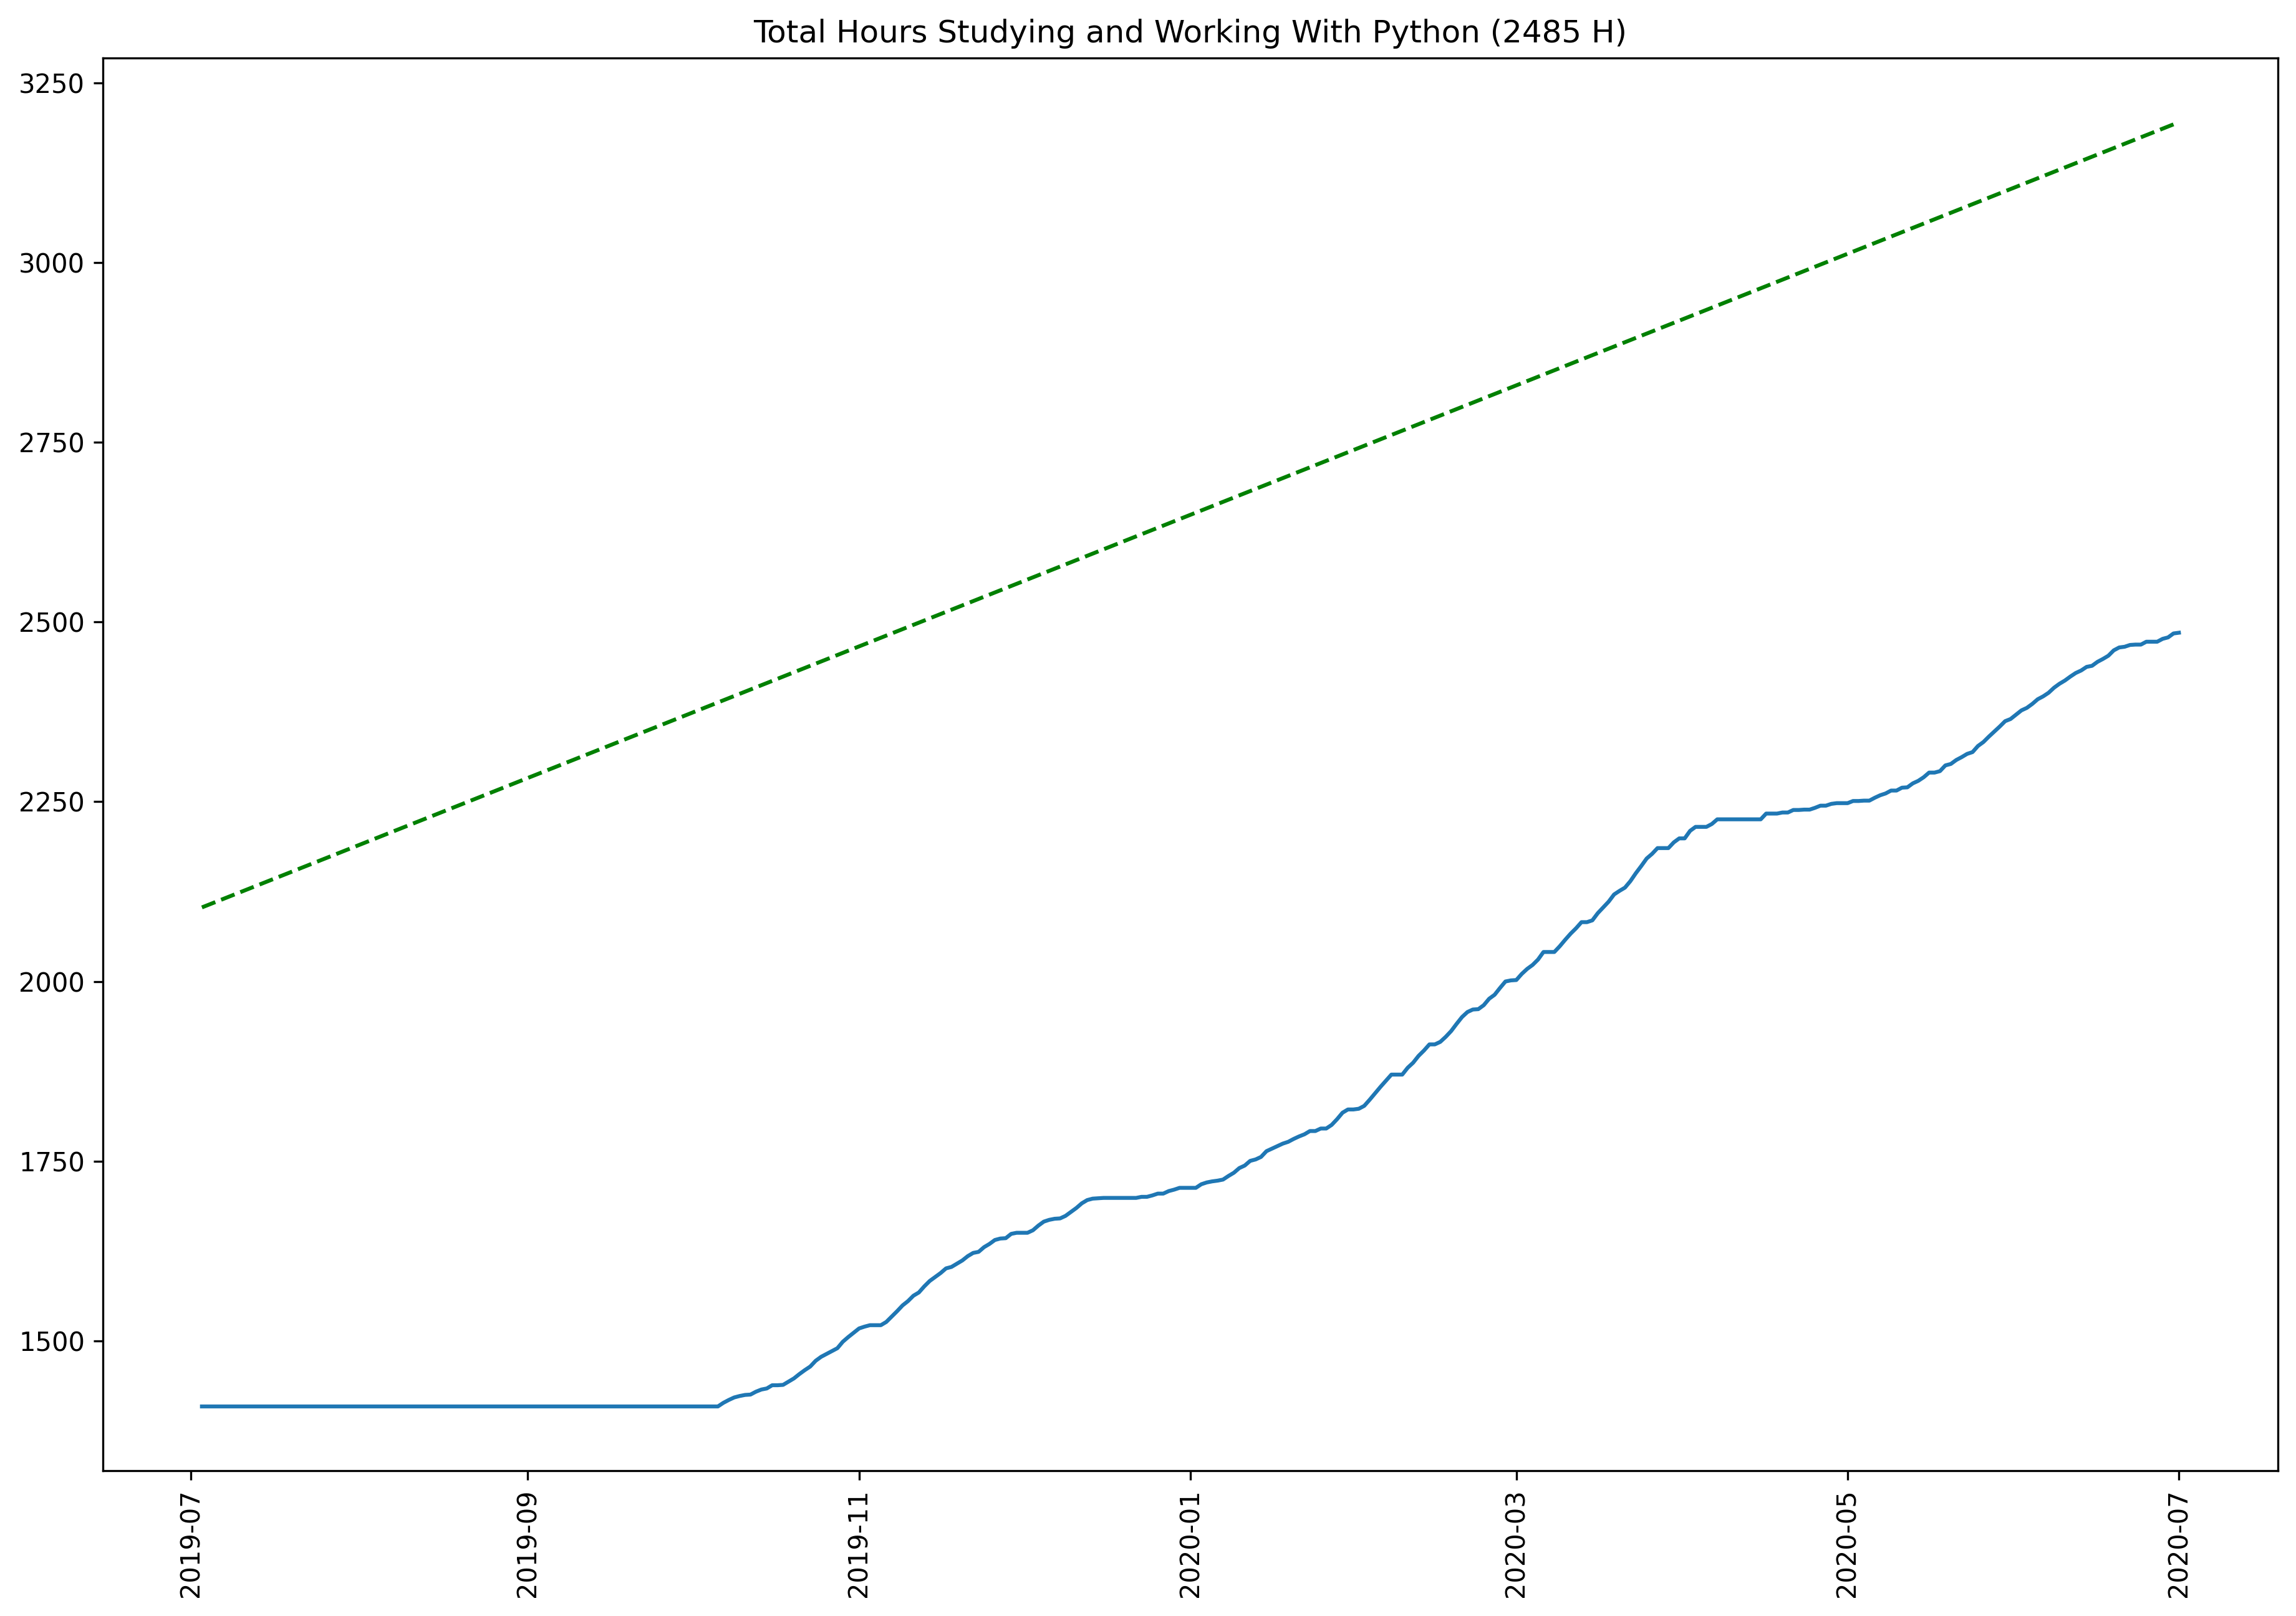

In [125]:
practice_plot(rs_df.iloc[start:])

#Current Year Analysis 

In [126]:
#we create a 
#current day vector 
#current month vector (int)
#current year vector (int)
today=datetime.now()
actual_month=today.month
actual_year=today.year
print(type(actual_year))

#we convert to string 
#current year vector 
year_str=str(actual_year)
d=1
#we create
#a starting point 
#for current year  
#that is the 1 of January
date2=datetime(actual_year,1,1)

#we create a 
#current month threshold 
filtering_threshold=datetime(actual_year,actual_month,d)
#we filter 
#the python activities df
#based on the current month 
python_act_m=pythondf[pythondf.index>=filtering_threshold]

#we filter 
#the python activities df
#based on the current year
python_act_y=pythondf[pythondf.index>=year_str]
#we calculate
#the numbers of days 
#from
#the beginning of the month 
#and the current day 
d_day=(today-filtering_threshold).days
#we calculate
#the numbers of days 
#from
#the beginning of the year
#and the current day 
d_y_day=(today-date2).days

print('Python monthly head \n', python_act_m.head())
print('Python yearly head \n', python_act_y.head())


<class 'int'>
Python monthly head 
             Year  Month  Day  Time  ...  End  Activity     Cum  Costant_CUM
Date                                ...                                    
2020-07-01   2.0    2.0  2.0   2.0  ...  2.0       2.0  2485.0         3195

[1 rows x 10 columns]
Python yearly head 
             Year  Month   Day  Time  ...   End  Activity     Cum  Costant_CUM
Date                                 ...                                     
2020-01-01   0.0    0.0   0.0   0.0  ...   0.0       0.0  1713.0         2649
2020-01-02   0.0    0.0   0.0   0.0  ...   0.0       0.0  1713.0         2652
2020-01-03  10.0   10.0  10.0  10.0  ...  10.0      10.0  1718.0         2655
2020-01-04   5.0    5.0   5.0   5.0  ...   5.0       5.0  1720.5         2658
2020-01-05   3.0    3.0   3.0   3.0  ...   3.0       3.0  1722.0         2661

[5 rows x 10 columns]


Max Hours of practice with  Python  is 2485 h
Python Logs starts 2017-08-02 and they end 2020-07-01
The difference between the actual cumulated hours and the ideal cumulated hours is: -710.0 hours 

Spread between Ideal and Actual hours reduced by 2.87  in the past 30 days 
Spread between Ideal and Actual hours reduced by 0.42  in the past 90 days 
Spread between Ideal and Actual hours reduced by 24.27  in the past 180 days 


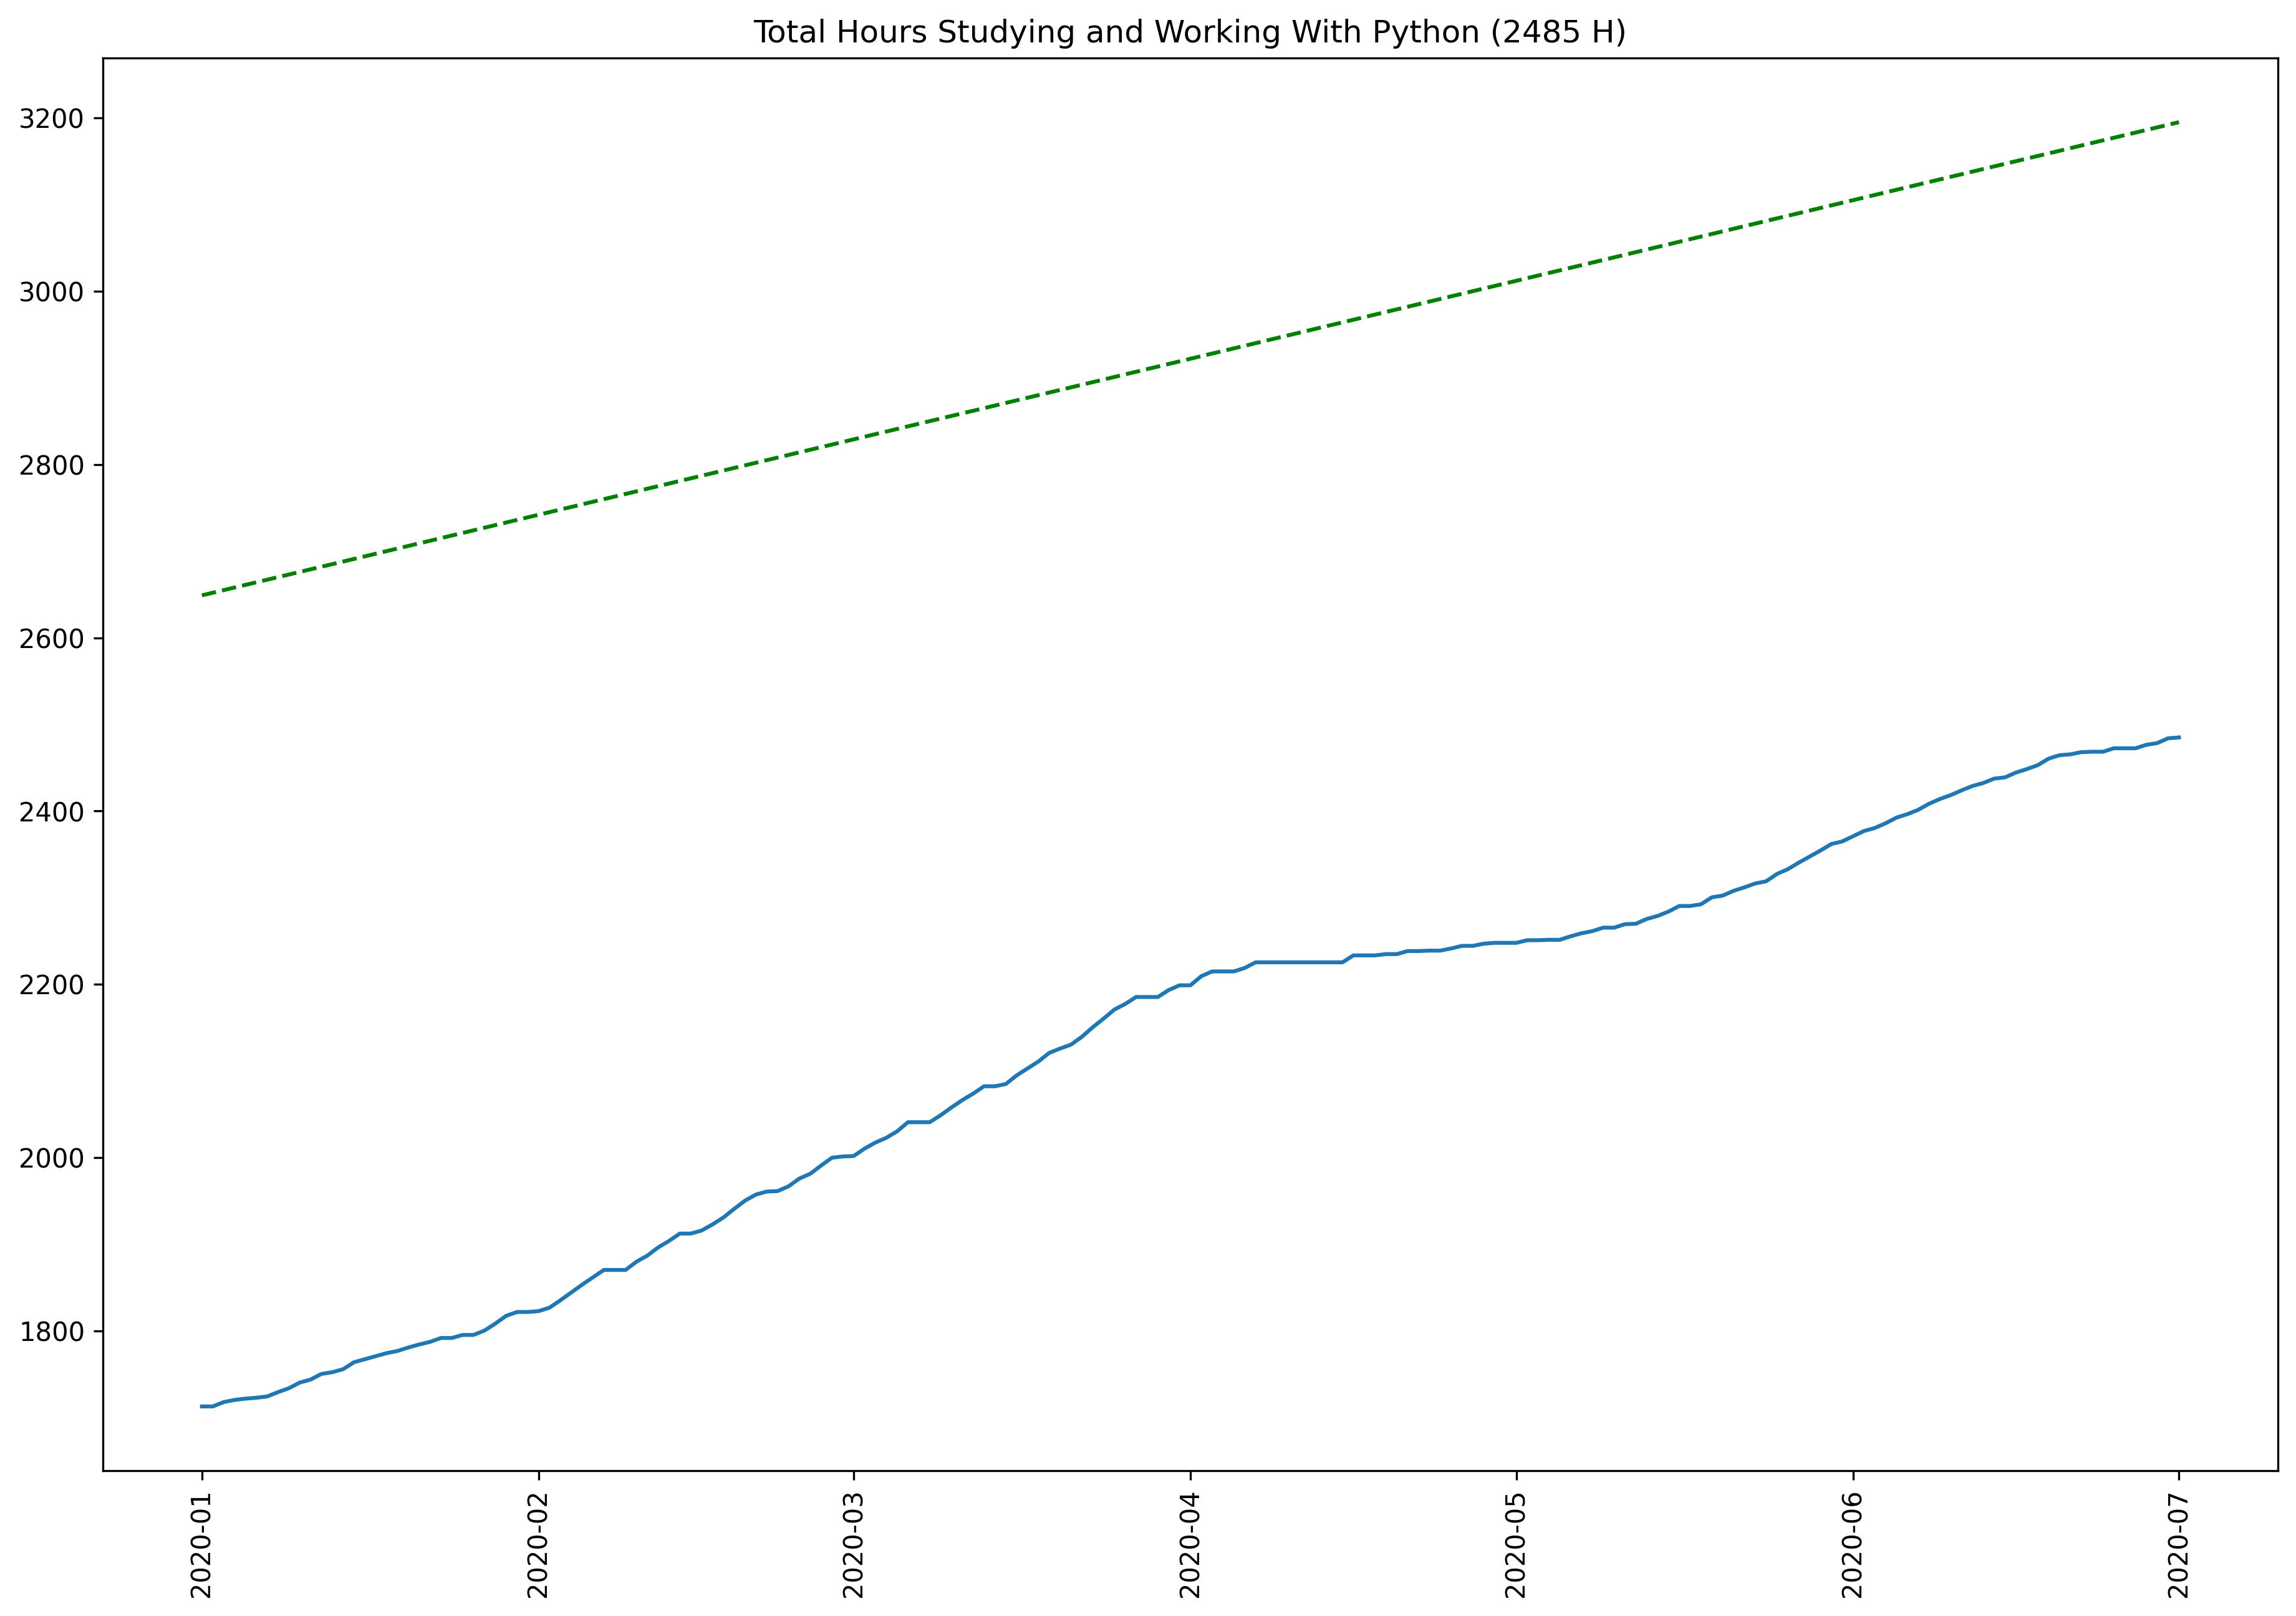

In [127]:
practice_plot(python_act_y)

In [128]:
#This is a relative plot in order 
#to analyze the learning trend 
#relative to 
#the current year 
#current month 
def relative_plot(df,date): 
    #we filter the data frame based on date
    f_df=df[date::].copy()
    #we calculate the actual relative cumulated column
    f_df['R_Cum']=f_df['Activity'].cumsum().divide(2)
    #here we create the ideal relative cumulated column 
    f_df['R_Costant_CUM']=np.arange(3,len(f_df)*3+1,3)
    #here we extract the relative value 
    #of the ideal and real cumulated function
    maxh=f_df.R_Cum.max()
    maxc=f_df.R_Costant_CUM.max()

    print("Python Practice since",date," are %s h"%maxh)
    #spread between the two maximum values 
    delta=maxh-maxc
    print("The relative spread between the ideal and the actual hours is equal to %s h"%delta)
    #Plotting the results 
    fig, ax= plt.subplots(facecolor='white', dpi=300)
    ax.plot(f_df.index,f_df['R_Cum'])
    ax.plot(f_df.index,f_df['R_Costant_CUM'],'g--')
    ax.tick_params(axis='x',rotation=90)
    ax.set(title='Relative Hours Studying and Working With Python (%d H)'%(maxh))
    
    plt.show()
    return 

Python Practice since 2020  are 772.0 h
The relative spread between the ideal and the actual hours is equal to 223.0 h


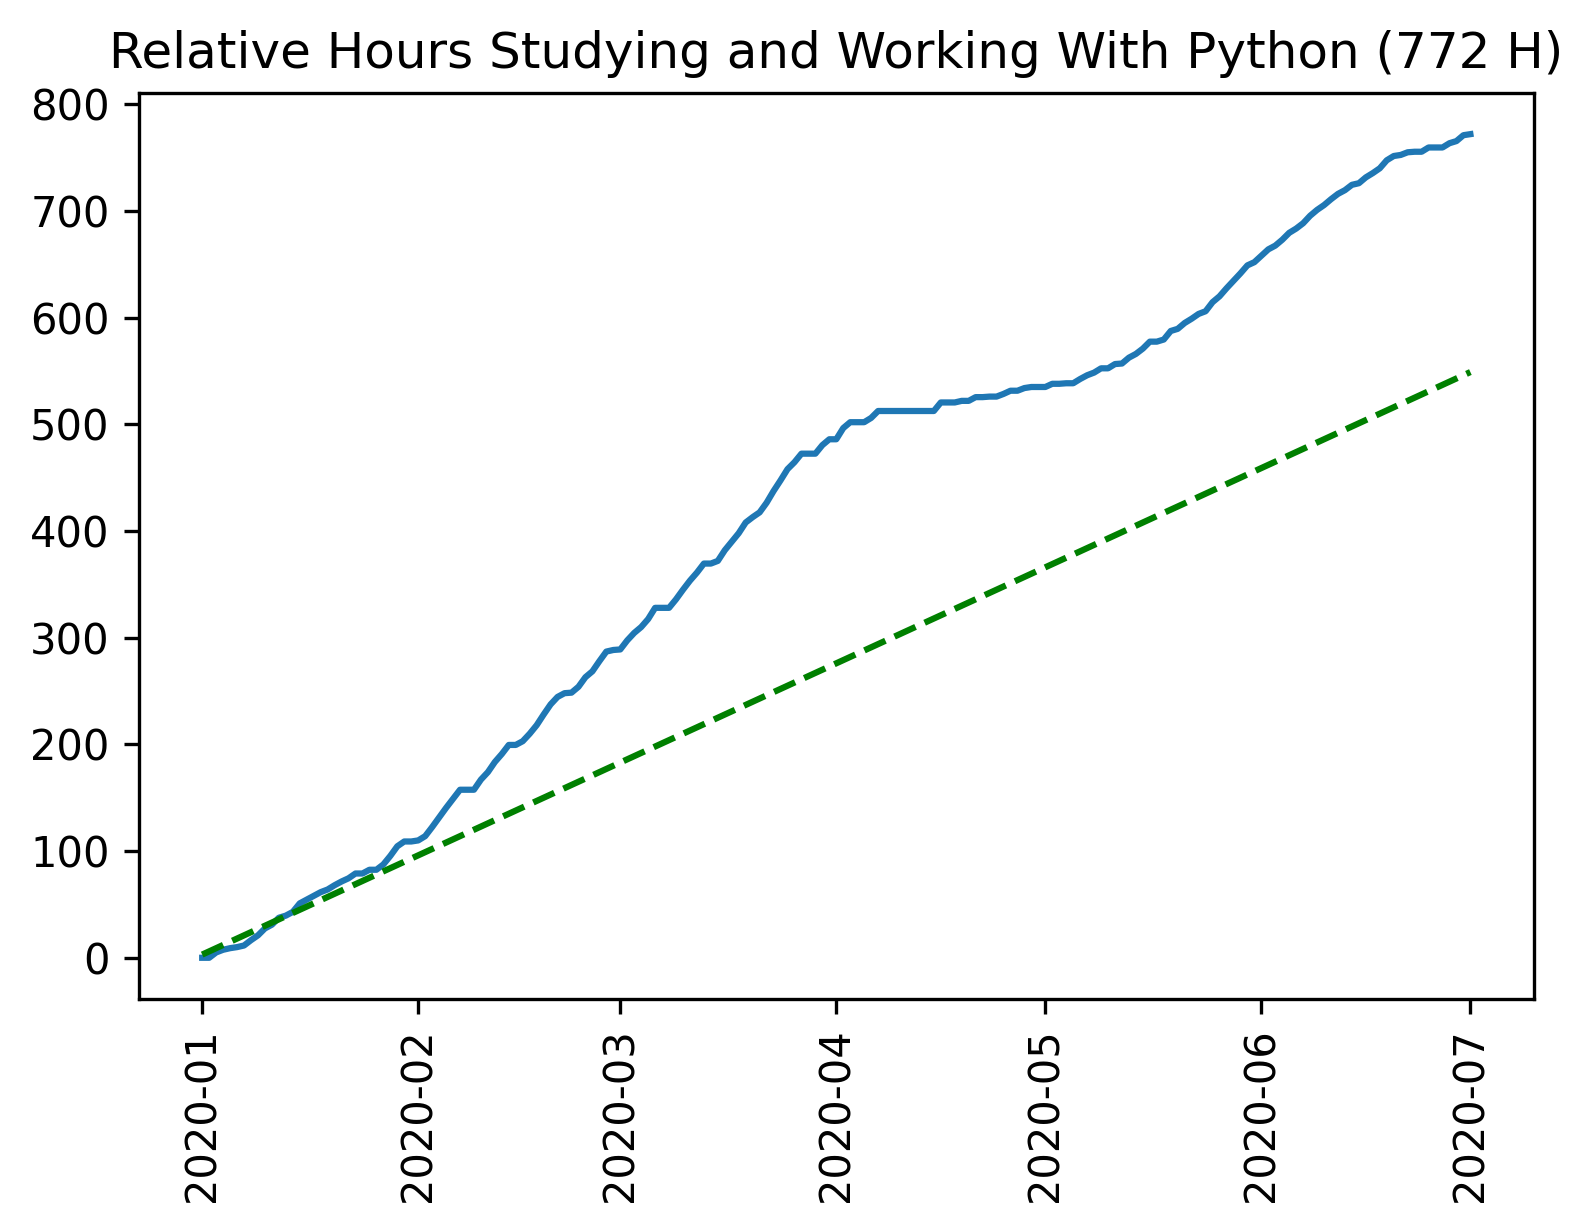

In [129]:
year='2020'
relative_plot(rs_df,year)

In this section we analyze how we are performing on monthly basis and on yearly basis
We should select manually the month and the year, this way is also possible to go back to any month 

In [130]:
month='2020-03'

Python Practice since 2020-03  are 483.5 h
The relative spread between the ideal and the actual hours is equal to 114.5 h


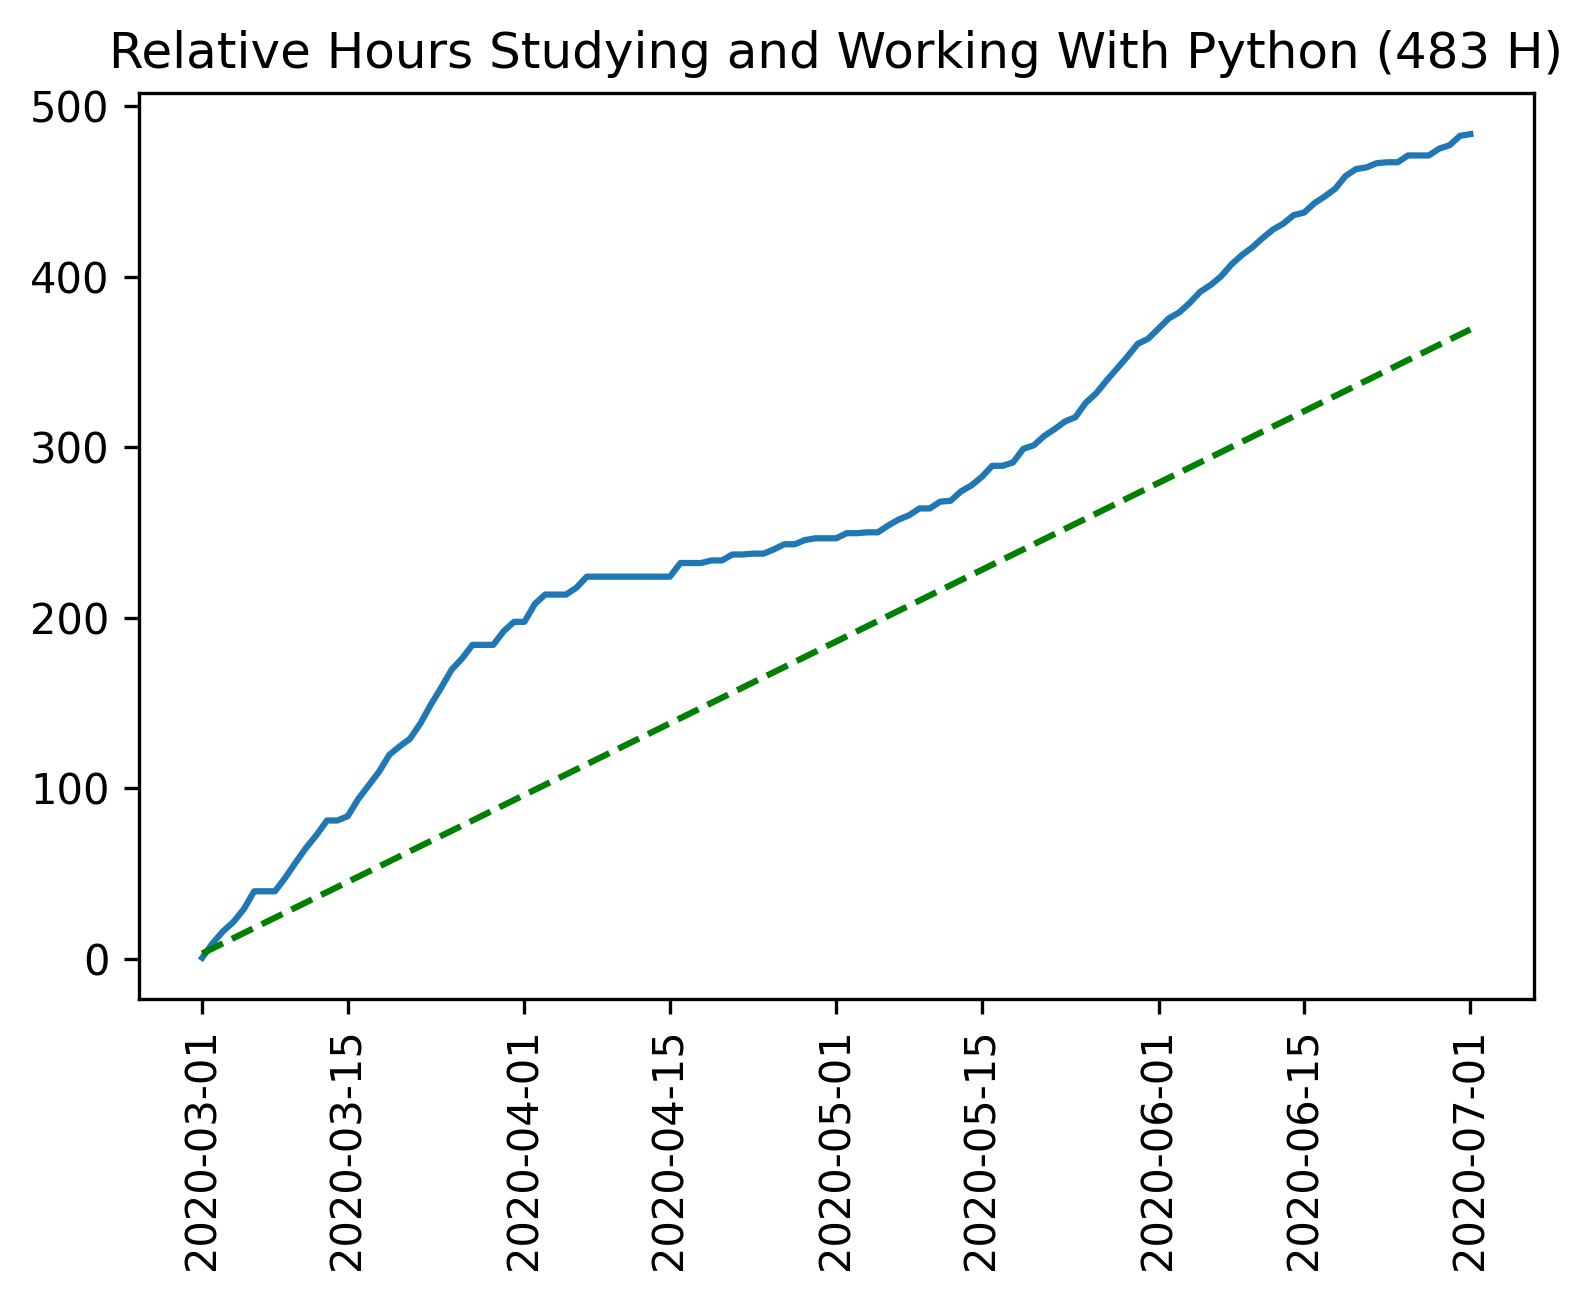

In [131]:
relative_plot(rs_df,month)

Max Hours of practice with  Python  is 2485 h
Python Logs starts 2017-08-02 and they end 2020-07-01
The difference between the actual cumulated hours and the ideal cumulated hours is: -710.0 hours 

Spread between Ideal and Actual hours reduced by 2.87  in the past 30 days 
Spread between Ideal and Actual hours reduced by 0.42  in the past 90 days 
Spread between Ideal and Actual hours reduced by 24.27  in the past 180 days 


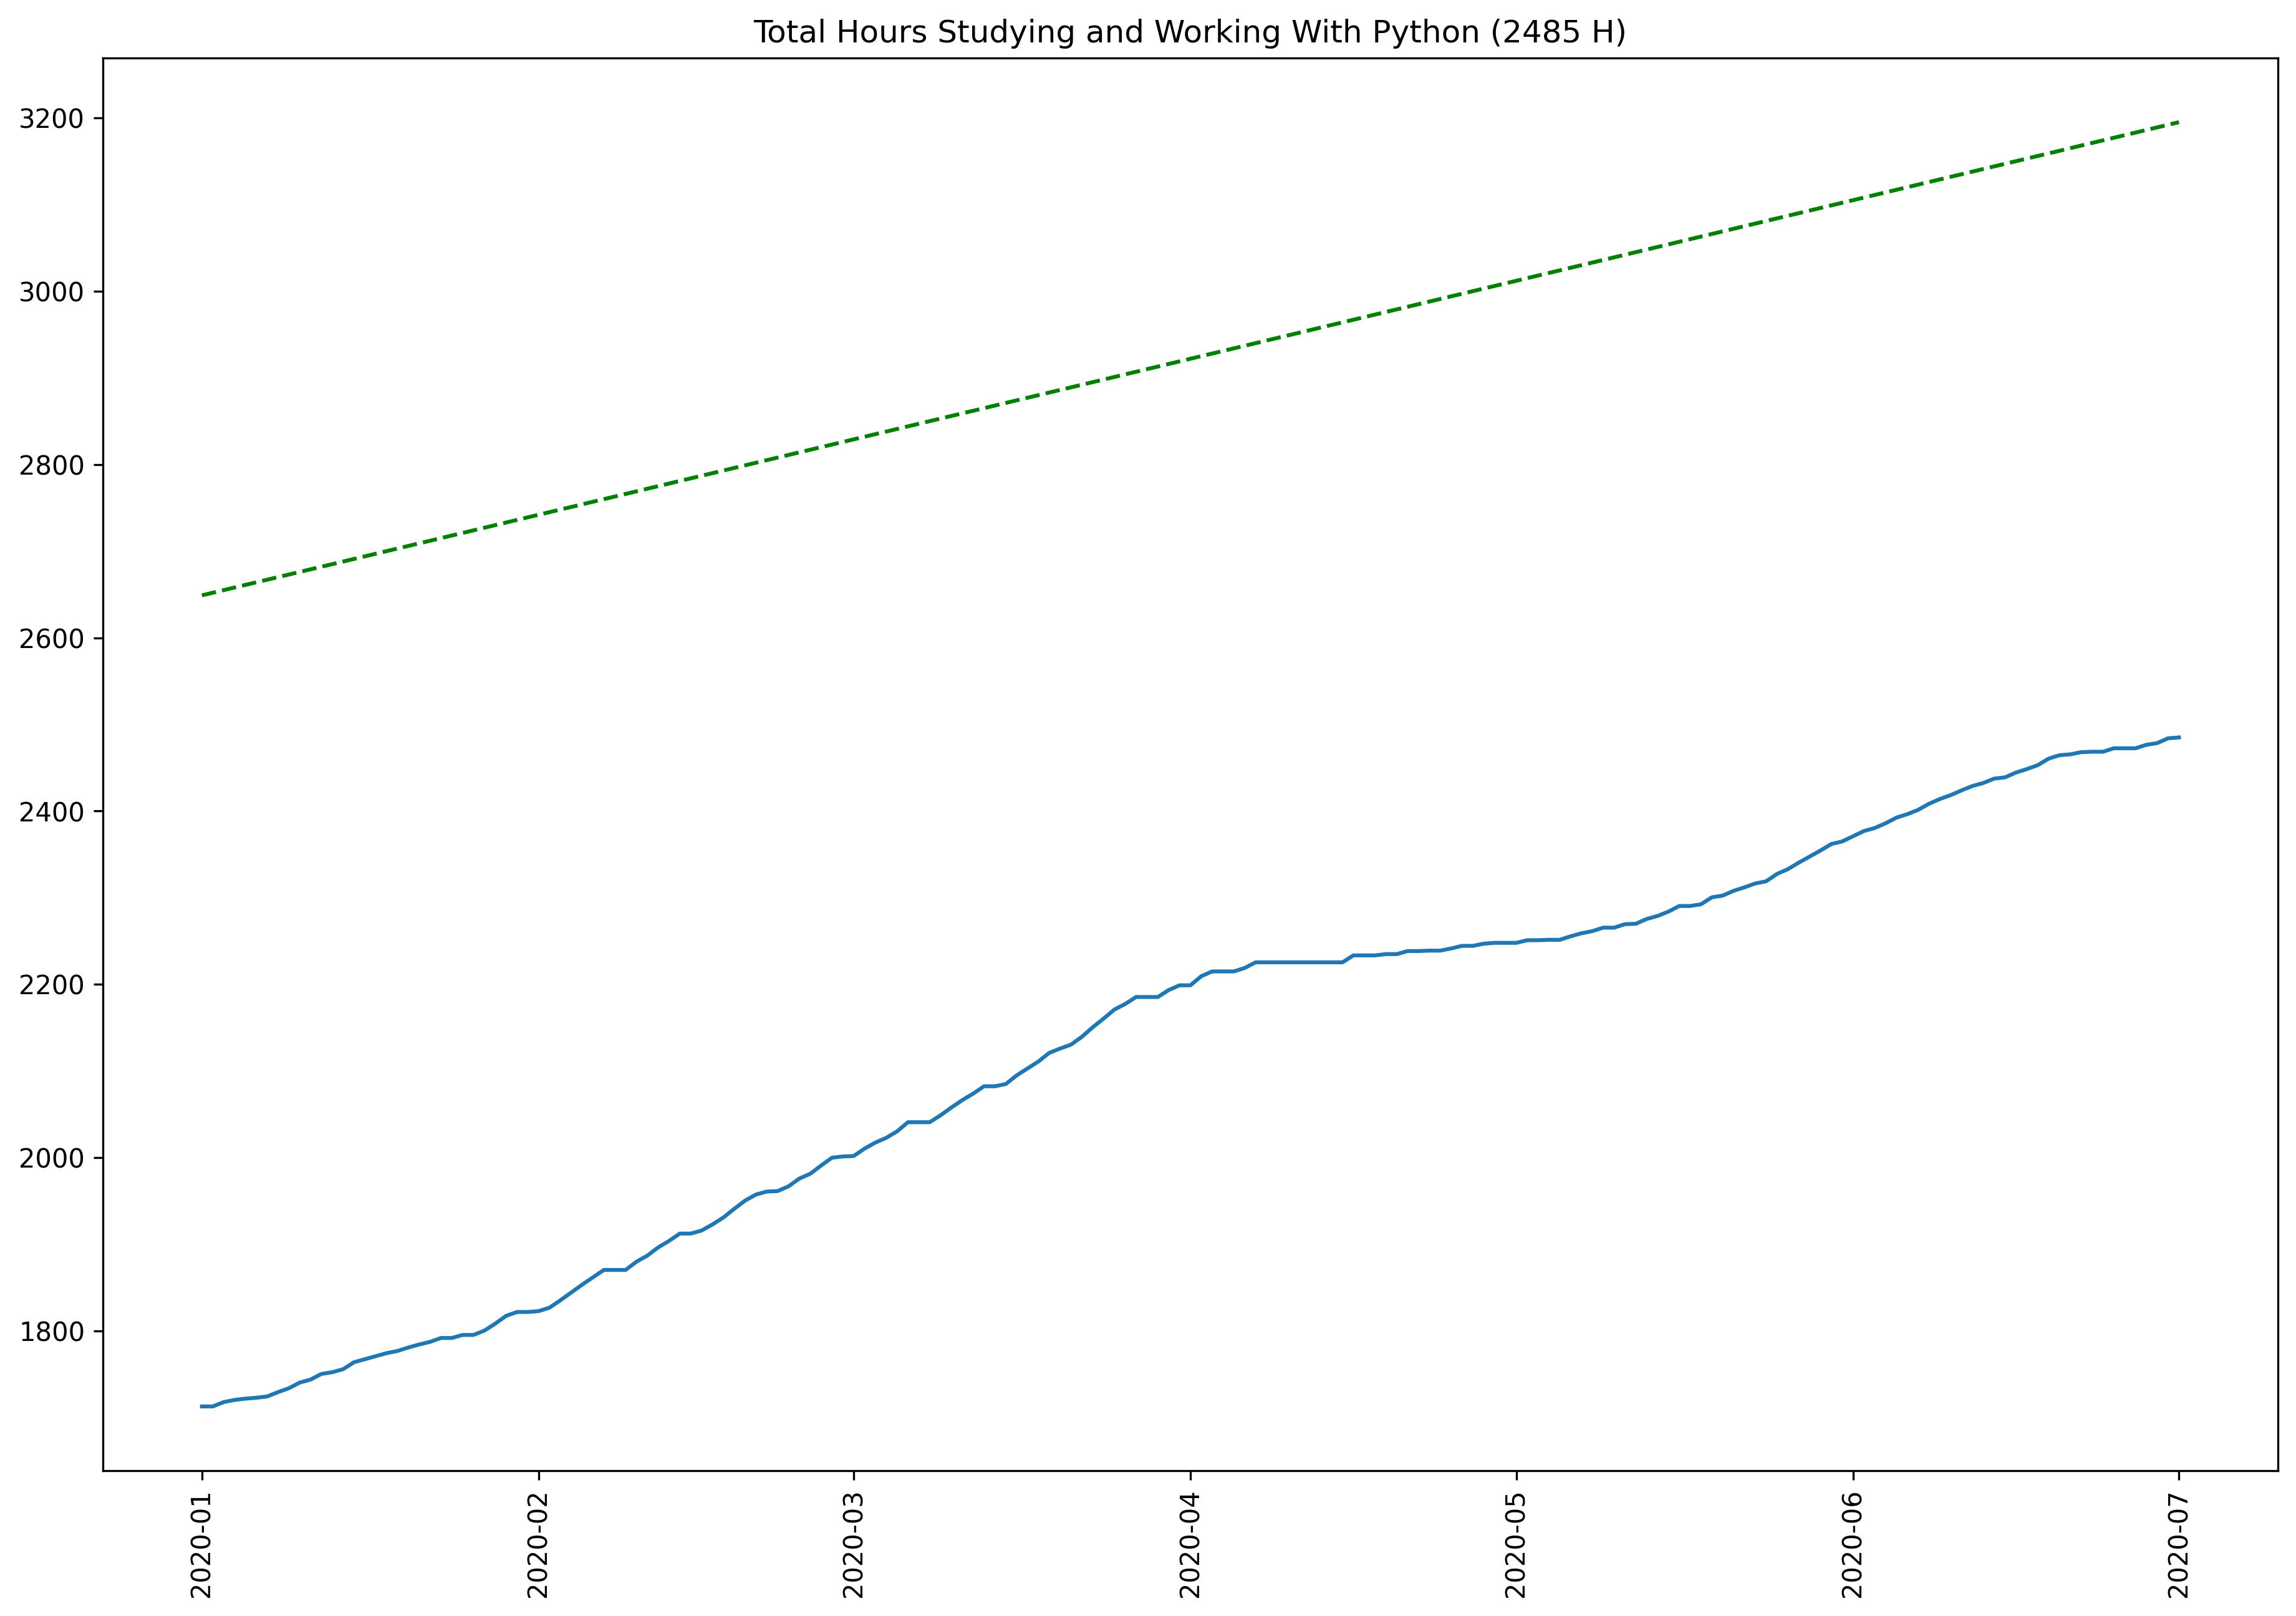

Python Practice since 2020  are 772.0 h
The relative spread between the ideal and the actual hours is equal to 223.0 h


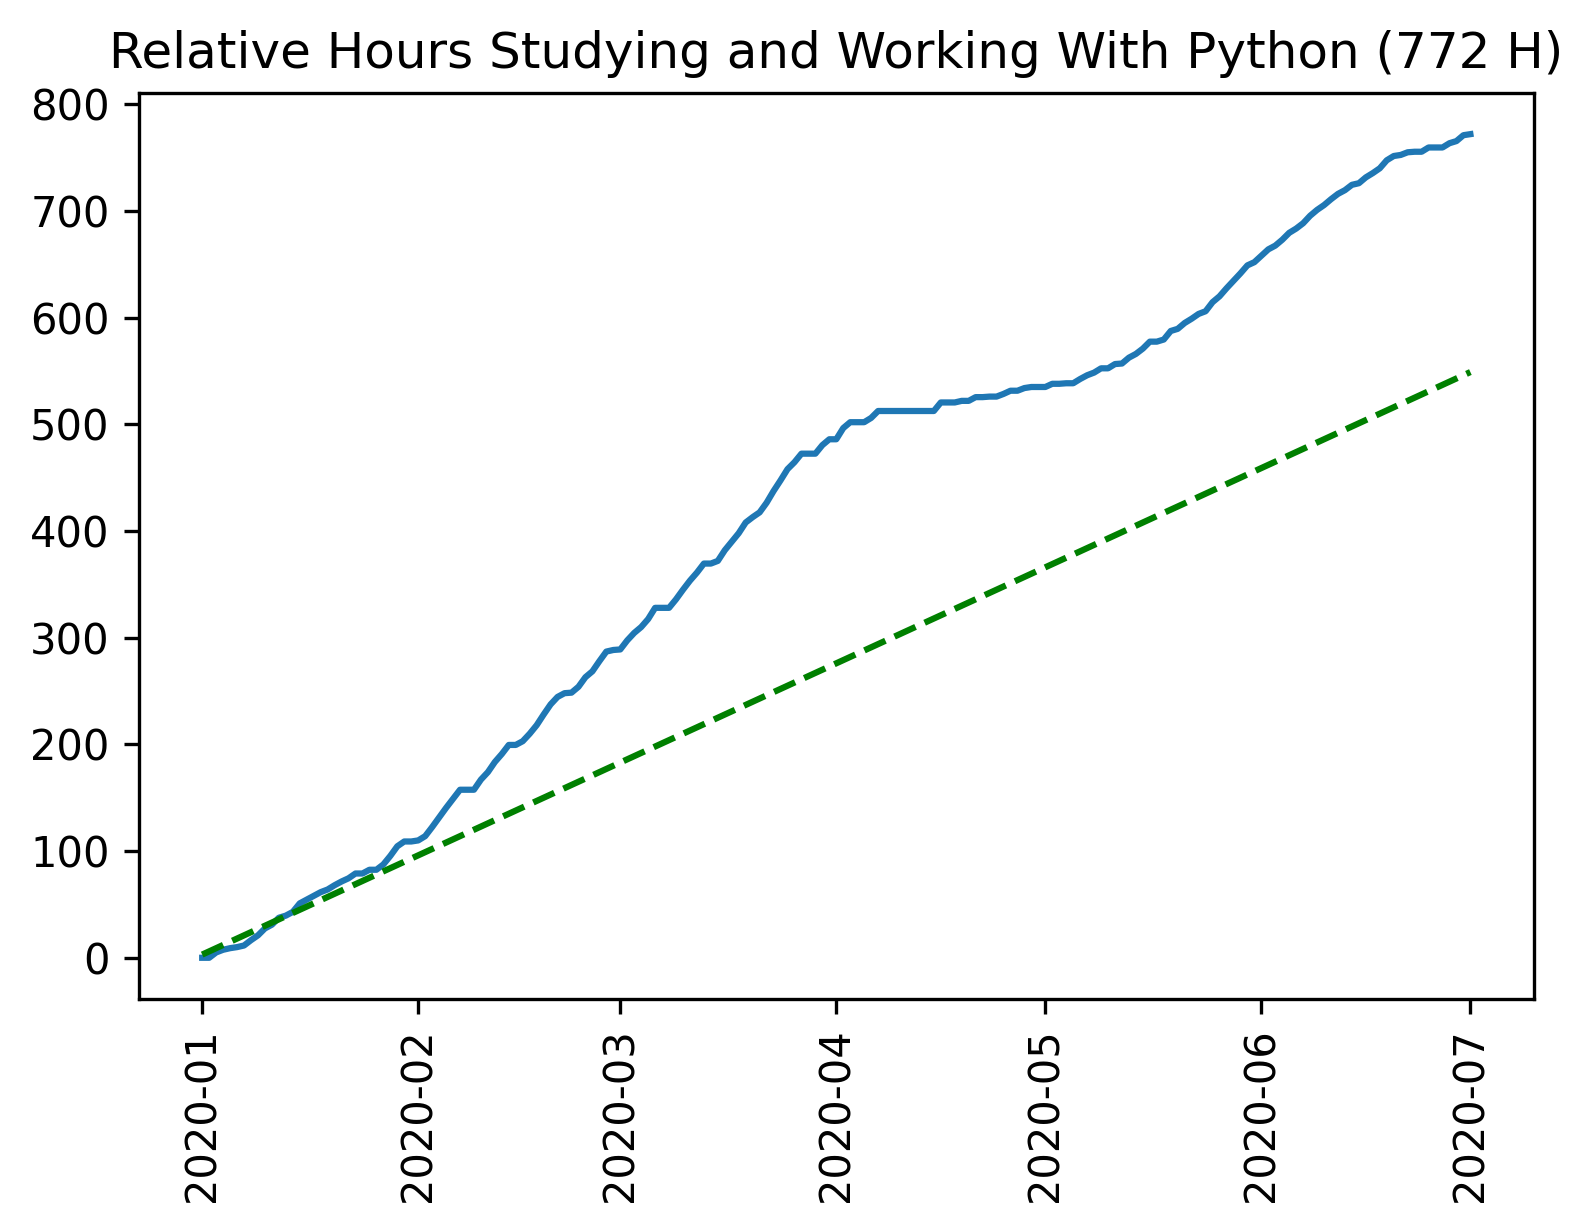

In [132]:
practice_plot(python_act_y)
relative_plot(rs_df,year)

#Goal Forcasting 

In this section we start analyzing the time series, also for a self-learning reason, in order to get some information about future 

#DON'T TRY THIS AT HOME

We will develop some estimations based on: 

*   Normal Gaussian Distribution
*   Markov Inequality
*   Moving average
*   Non stationary process
    

Don't be scared about my choice, I know that is a strong assumption and is not true, but i will consider days as Independent and Identically Distributed 



In [133]:
#we never trasformed and replaced Activity 
#from half hours to hours
#we have done a trasnformation referring 
#to the Actual Cumulative column
#so we need in order to have an hourly idea
#to divide by two the activity column
#rs_df contains all the python logs since they were recorded
activity_divided=rs_df.Activity.divide(2)
print("Printing Selected Activity Mean:")
print(round(activity_divided.mean(),2))
print("Printing Selected Activity STD:")
print(round(activity_divided.std(),2))
print("Printing Selected Activity Median:")
print(round(activity_divided.median(),2))
print("Printing activity_divided DataFram basic stats:")
print(activity_divided.describe().round(2))

Printing Selected Activity Mean:
2.33
Printing Selected Activity STD:
2.8
Printing Selected Activity Median:
1.5
Printing activity_divided DataFram basic stats:
count    1065.00
mean        2.33
std         2.80
min         0.00
25%         0.00
50%         1.50
75%         4.00
max        16.00
Name: Activity, dtype: float64


## Markov's Inequality Applied
Just for learning Markov's Inequality gives an upper bound for the probability that a non-negative function of a random variable is greater than or equal to some positive constant.

We will take the daily average value of the hours dedicated to the Pyhton practice until now. 

We will derive from year in a very basic way the remaining time to become an expert, and we will get the probability

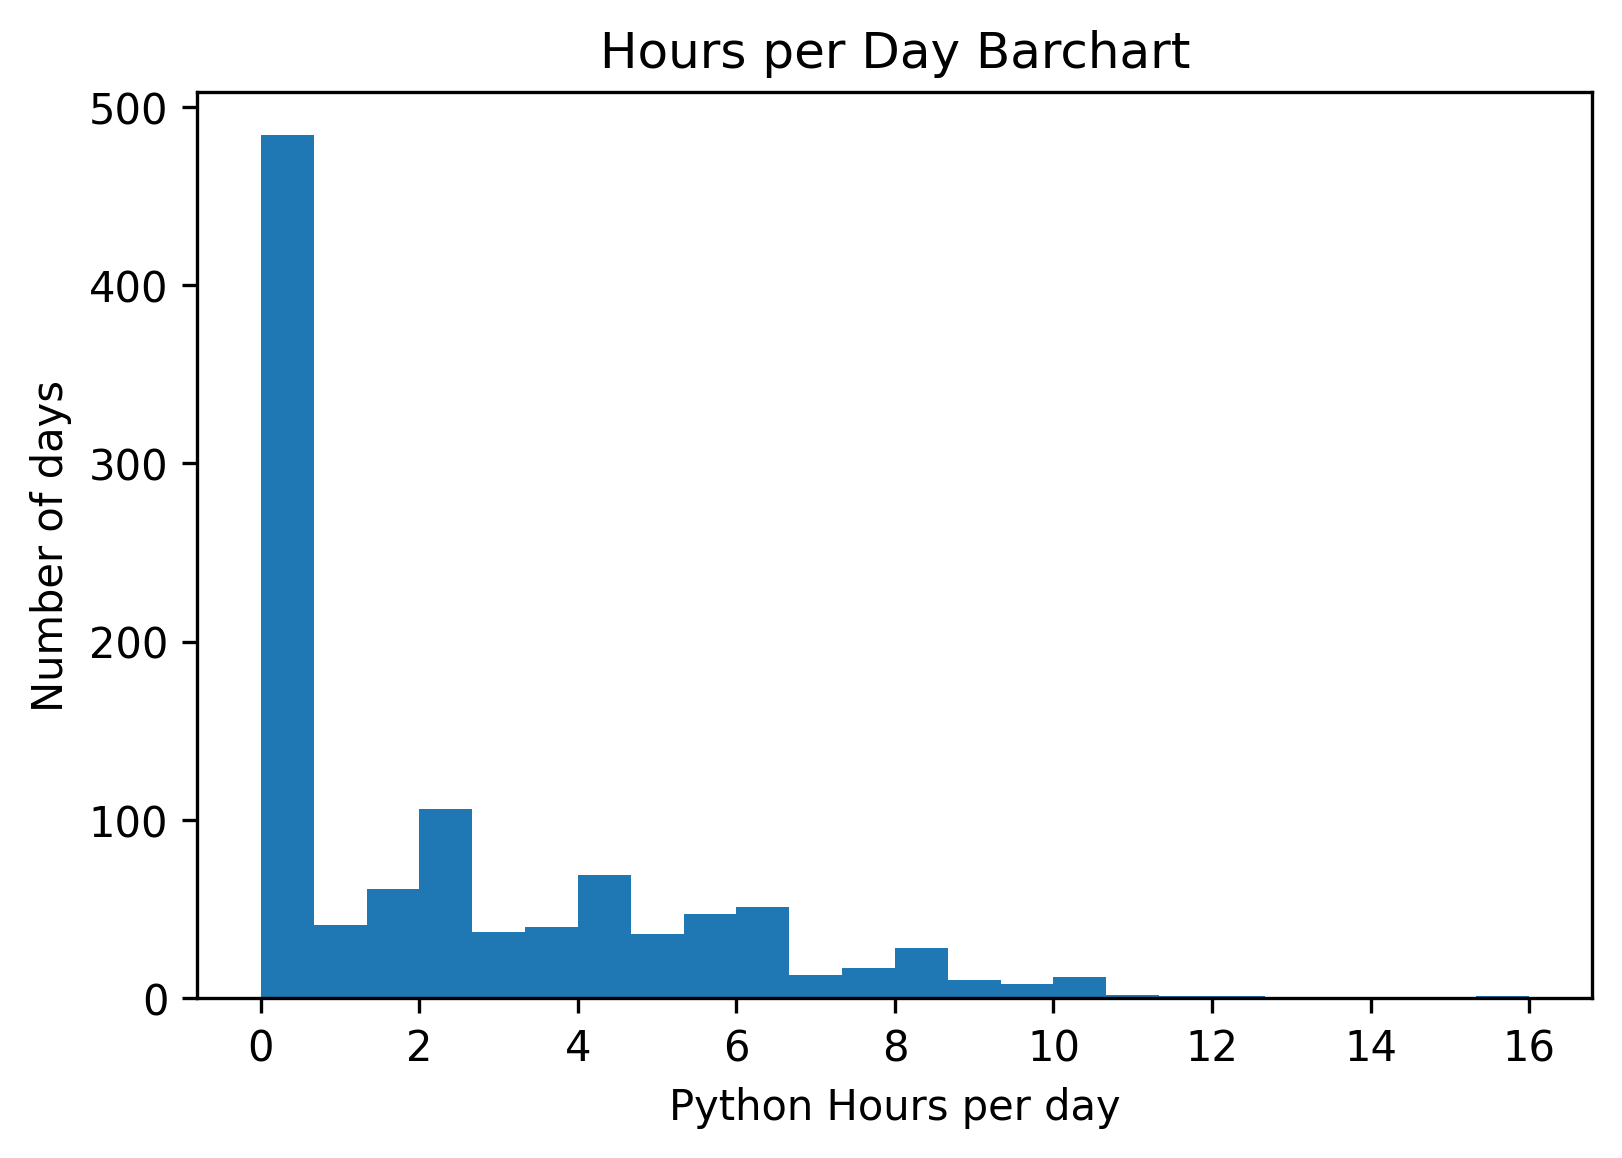

In [134]:
#Here we want to see the hours distribution 

fig, ax=plt.subplots(facecolor='white', dpi=300)
ax.hist(activity_divided,bins=24)
ax.set(xlabel='Python Hours per day',ylabel='Number of days',
       title='Hours per Day Barchart')
plt.show()

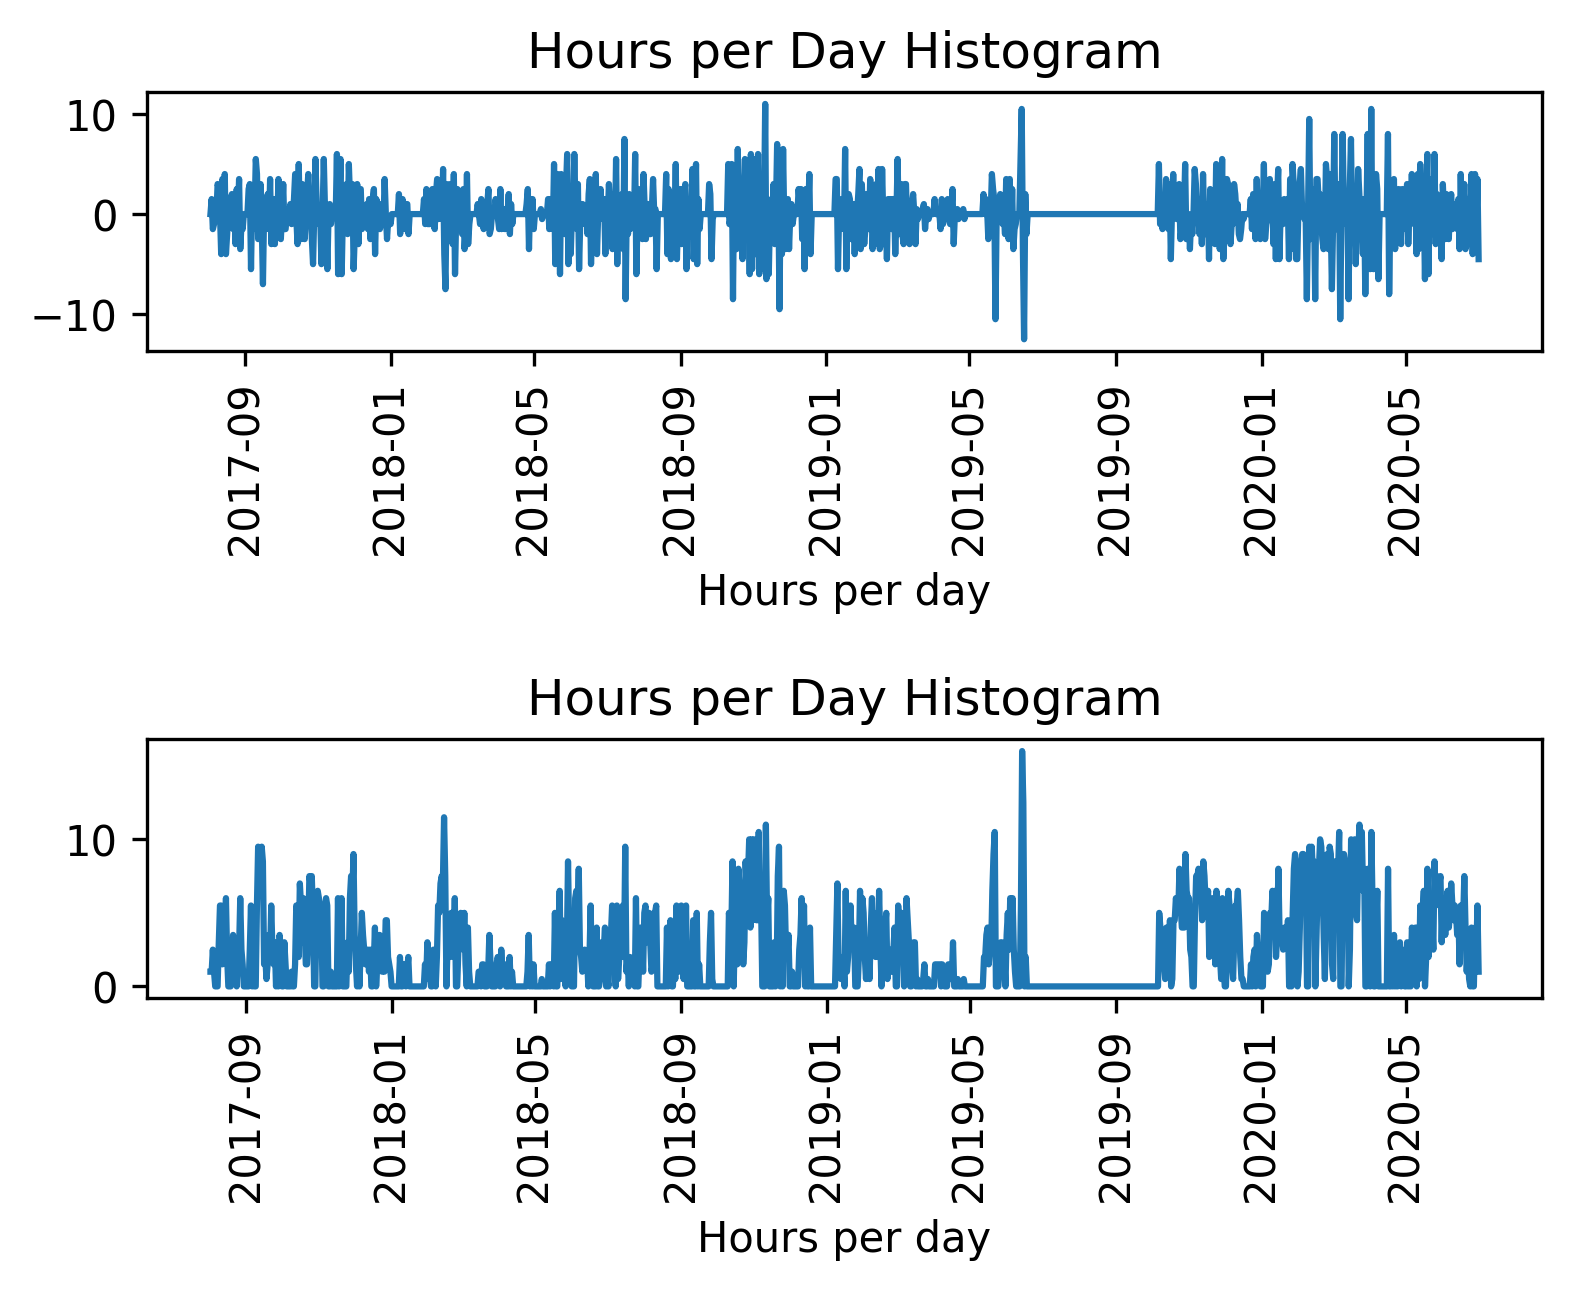

In [135]:
#we try to analyze the difference 
#in the total hours between adjacent days
#when it's positive we studied more the day after
#when it's negative we studied less the day after 

diff=activity_divided.diff().dropna()

fig, ax=plt.subplots(2,1,facecolor='white', dpi=300)
ax[0].plot(diff.index,diff)
ax[0].set(xlabel='Hours per day',title='Hours per Day Histogram')
plt.setp(ax[0].get_xticklabels(),rotation=90)
ax[1].plot(activity_divided.index,activity_divided)
ax[1].set(xlabel='Hours per day',title='Hours per Day Histogram')
plt.setp(ax[1].get_xticklabels(),rotation=90)
plt.subplots_adjust(hspace=1.5)
plt.show()

Diff Summary Statistics: 
 count    1064.000000
mean        0.000000
std         2.628987
min       -12.500000
25%        -1.000000
50%         0.000000
75%         1.000000
max        11.000000
Name: Activity, dtype: float64


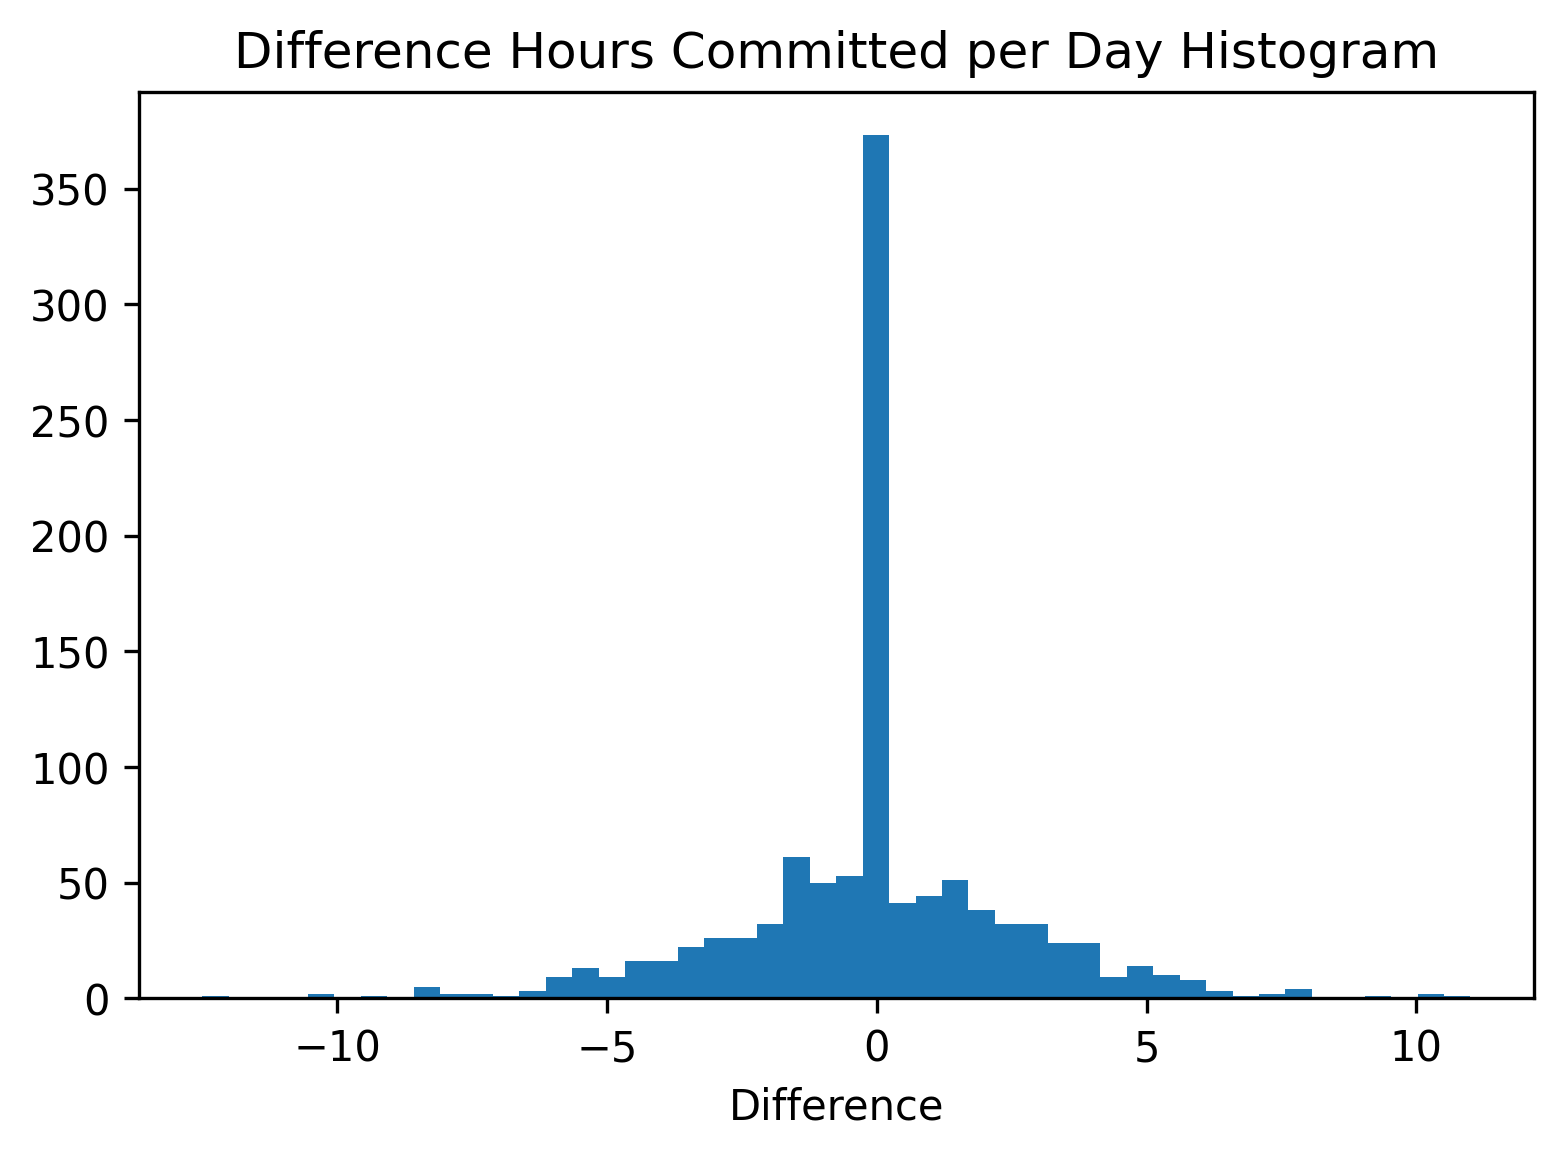

In [136]:
#here we plot the histogram of
#the difference between adiacent days in activity day 
print("Diff Summary Statistics: \n",diff.describe())
fig, ax=plt.subplots(facecolor='white', dpi=300)
ax.hist(diff,bins=48)
ax.set(xlabel='Difference',title='Difference Hours Committed per Day Histogram')
plt.show()

In [137]:
#we create 
#a normal distribution 
#with 
#mean equal to the average hours per day 
#std is calculated also on daily basis
n_mean=rs_df.Activity.divide(2).mean()
n_std=rs_df.Activity.divide(2).mean()
n_obj=scipy.stats.norm(n_mean, n_std).cdf(n_mean)
print(n_obj)

          
normal_obj=np.random.normal(n_mean, n_std,1000)
normal_sorted=sorted(normal_obj)
percentile=[2.5,25,50, 75,97.5]
percentile_100=[0.025,0.25,0.50, 0.75,0.975]
norm_ppf=scipy.stats.norm(n_mean, n_std).ppf(percentile_100)
print("Printng the Percent Point Distribution from ideal normal distribution:")
print(norm_ppf)
prc_array=np.percentile(normal_sorted,percentile)
print("Percentile array from a Normal Sampled Distribution \n", prc_array)
print(prc_array.size)
remaining_days=np.full(prc_array.size,remaining_h)
print("Year remaining to be an expert \n",(remaining_days/prc_array)/365)

0.5
Printng the Percent Point Distribution from ideal normal distribution:
[-2.23991596  0.75952392  2.33333333  3.90714275  6.90658263]
Percentile array from a Normal Sampled Distribution 
 [-2.23261659  0.83654463  2.49392987  3.89924046  6.62785996]
5
Year remaining to be an expert 
 [-9.22193323 24.61200569  8.25566162  5.28026966  3.10643876]


Some resources relative to:

1) Normal Distribution

2) Beta Distribution

3) PERT Distribution 

https://www.vosesoftware.com/riskwiki/Beta4distribution.php

https://it.wikipedia.org/wiki/Distribuzione_Beta

https://en.wikipedia.org/wiki/PERT_distribution

https://stats.stackexchange.com/questions/68983/beta-distribution-fitting-in-scipy

https://medium.com/w2hds/beta-distribution-what-when-how-c5ebaafdeedd

https://bizfluent.com/how-6722338-calculate-pert.html

https://math.stackexchange.com/questions/521575/difference-between-probability-and-probability-density

In [138]:
#in this section we identify autocorrelation for our time series
#
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


In [139]:
#Try to approximate the actual curve with polynomial features 
#Is a trivial way to make a prediction 
#Just for practice
#not for pratical use 
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller

In [140]:
print(rs_df.head(5))
print(today)

            Year  Month  Day  Time  ...  End  Activity  Cum  Costant_CUM
Date                                ...                                 
2017-08-02   2.0    2.0  2.0   2.0  ...  2.0       2.0  1.0            3
2017-08-03   2.0    2.0  2.0   2.0  ...  2.0       2.0  2.0            6
2017-08-04   5.0    5.0  5.0   5.0  ...  5.0       5.0  4.5            9
2017-08-05   2.0    2.0  2.0   2.0  ...  2.0       2.0  5.5           12
2017-08-06   0.0    0.0  0.0   0.0  ...  0.0       0.0  5.5           15

[5 rows x 10 columns]
2020-07-06 13:08:20.957270


In [141]:
degree=1
model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
x=np.arange(0,len(rs_df.index))
x=x[:,np.newaxis]
y=np.array(rs_df['Cum'].values)
y=y[:,np.newaxis]
print(len(x))
print(len(rs_df['Cum']))
print(len(x),x.shape)
print(len(y),y.shape)
fitted=model.fit(x,y)
x_pred=np.arange(0,len(rs_df.index)+365)
x_pred=x_pred[:,np.newaxis]
y_plot = model.predict(x_pred)
print(type(model))
print(type(fitted))
#we need to get another y pred 
#in order to evaluate 
#the residuals 
y_res=model.predict(x)
residuals=y_res-y
flat_residuals=residuals.flatten()
print(adfuller(flat_residuals))

1065
1065
1065 (1065, 1)
1065 (1065, 1)
<class 'sklearn.pipeline.Pipeline'>
<class 'sklearn.pipeline.Pipeline'>
(-1.174255383648933, 0.6845712137737741, 15, 1049, {'1%': -3.4365991650067502, '5%': -2.864299173128419, '10%': -2.5682390922672735}, 4613.842167288794)


In [142]:
#thorugh statsmodel ordinary least squared 
#we extract automatically residuals 
#and test if they are stationary or not 
import statsmodels.api as sm
#
X = sm.add_constant(x)
model_stat = sm.OLS(y,X)
results_stats = model_stat.fit()
print(results_stats.params)
#we test if residuals are stationary or not 
#with adfuller test
print(adfuller(results_stats.resid))

[-4.7246818   2.07640013]
(-1.1742553836489587, 0.6845712137737633, 15, 1049, {'1%': -3.4365991650067502, '5%': -2.864299173128419, '10%': -2.5682390922672735}, 4613.842167288792)


[2962.45110513]
[2.07]


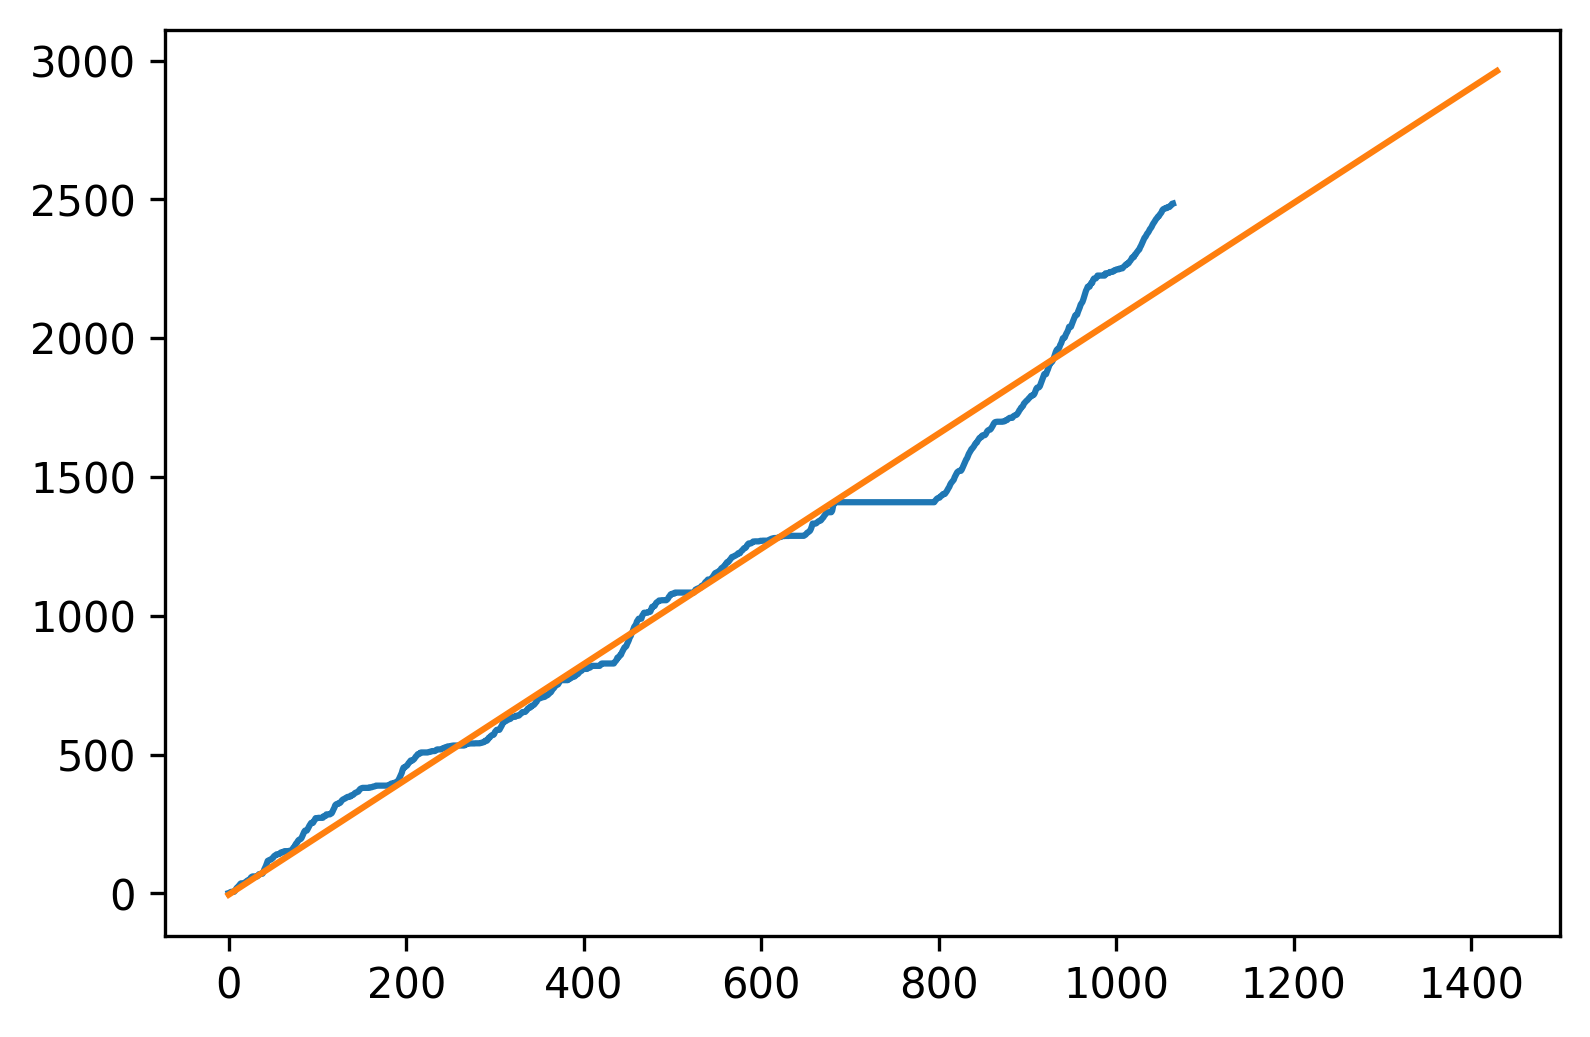

In [143]:
fig = plt.figure(facecolor='white', dpi=300)
ax = plt.axes()
ax.plot(x, y)
ax.plot(x_pred,y_plot)
print(y_plot[-1])
average=y_plot[-1]/len(y_plot)
print(np.round(average,2))

2.33


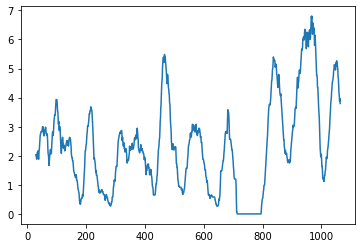

In [144]:
week_moving_average=rs_df.Activity.divide(2).rolling(window=30).mean()
mean_activity=round(rs_df.Activity.divide(2).mean(),2)
print(mean_activity)
x_moving=np.arange(0,len(week_moving_average))
fig,ax=plt.subplots()
ax.plot(x_moving,week_moving_average)
plt.show()

In this section we try to undestand if the difference between daily records is stationary with ad adfuller test 

In [145]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(diff)

print(result[0])
print("Adfuller p value:\n",np.round(result[1],4))

-11.237423483755537
Adfuller p value:
 0.0


# Forcasting Using Prophet 

In [146]:
#Importing Prophet
from fbprophet import Prophet

In [147]:
#Creating the dictonary that we will use to ingest data
activity_column=rs_df.Cum.iloc[:,]
date_column=rs_df.index
dict_series={'ds':date_column,'y':activity_column} 
#Creating the DataFrame that will be used as input for the 
#Prophet Model tuning 
prophet_df=pd.DataFrame(dict_series)

#Here we calculate the remaining days 
#to evaluate the how may days remain 
#at the end of the year 

#end of the year datetime 
end = datetime(datetime.today().year, 12, 31).date()
#today datetime 
today_datetime=today.date()
#
diff=(end-today_datetime).days
m = Prophet()
m.fit(prophet_df)
end_year=diff
future = m.make_future_dataframe(periods=diff)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#we should save the forecast containg in ds our evaluation day
last_forecast=forecast[['ds', 'yhat','yhat_lower',
                             'yhat_upper']].iloc[-1].copy()
print(last_forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds            2020-12-26 00:00:00
yhat                       3057.7
yhat_lower                 2651.2
yhat_upper                3432.67
Name: 1242, dtype: object


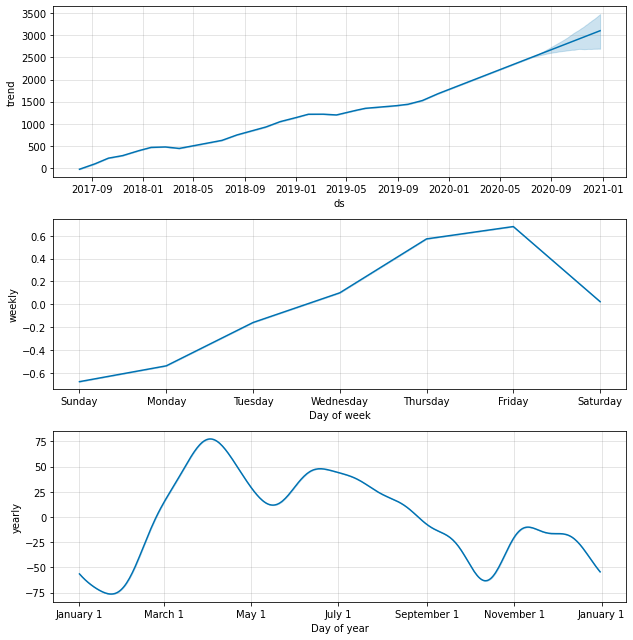

In [148]:
fig = m.plot_components(forecast)
plt.show()